In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

sns.set()

# Load original Database and set index

In [2]:
# Import the original file to the notebook
donors=pd.read_csv('donors.csv', index_col= 'CONTROLN')

In [3]:
#Set "CONTROLN" as index, because according to the metadata, this is the unique identifier for each customer
#donors = donors.set_index['CONTROLN']
donors.head()

,Unnamed: 0,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,...,TIMELAG,AVGGIFT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,...,4.0,7.741935,0,L,4,E,X,X,X,C
148535,1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,...,18.0,15.666667,0,L,2,G,X,X,X,A
15078,2,2010-01-01,AMH,1,NC,27017,,,NaN,0,...,12.0,7.481481,1,L,4,E,X,X,X,C
172556,3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,...,9.0,6.812500,1,L,4,E,X,X,X,C
7112,4,2006-01-01,,0,FL,33176,,,1940-01-01,0,...,14.0,6.864865,1,L,2,F,X,X,X,A


# Dtale

In [4]:
#used for initial data exploration
import dtale

dtale.show(donors, ignore_duplicate=True)

Executing shutdown due to inactivity...


2021-01-20 12:26:48,512 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2021-01-20 12:27:01,465 - INFO     - Executing shutdown...


# Database with all manually selected variables

In [5]:
#After careful evaluation using the explanation of the variables in the metadata, we selected the variables to
# use as initial input for automated filtering. 

#replace preferences with second set of variables. add any preprocessing. 
new_donors=donors[['STATE','MAILCODE','DOB','RECINHSE','RECP3','RECPGVG', 'RECSWEEP','DOMAIN','GENDER',
                   'HIT','MAXADATE','NUMPROM','NUMPRM12','RAMNTALL','NGIFTALL','MINRAMNT','MAXRAMNT','LASTGIFT',
                   'LASTDATE','FISTDATE','TIMELAG','AVGGIFT','RFA_2F', 'COLLECT1','VETERANS','BIBLE','CATLG','HOMEE',
                   'PETS','CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER',
                   'KIDSTUFF','CARDS','PLATES']]
new_donors.head()

,STATE,MAILCODE,DOB,RECINHSE,RECP3,RECPGVG,RECSWEEP,DOMAIN,GENDER,HIT,...,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,IL,,1957-12-01,,,,,T2,F,0,...,,,,,,,,,,
148535,CA,,1972-02-01,,,,,S1,M,16,...,,,,,,,,,,
15078,NC,,NaN,,,,,R2,M,2,...,,,,,,,,,,
172556,CA,,1948-01-01,,,,,R2,F,2,...,,,,,,,,,,
7112,FL,,1940-01-01,X,X,,,S2,F,60,...,,,Y,,Y,,Y,,Y,


In [6]:
#Create a copy of the manually filtered database to do some initial exploration
data=new_donors.copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95412 entries, 95515 to 185114
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   STATE     95412 non-null  object 
 1   MAILCODE  95412 non-null  object 
 2   DOB       71529 non-null  object 
 3   RECINHSE  95412 non-null  object 
 4   RECP3     95412 non-null  object 
 5   RECPGVG   95412 non-null  object 
 6   RECSWEEP  95412 non-null  object 
 7   DOMAIN    95412 non-null  object 
 8   GENDER    95412 non-null  object 
 9   HIT       95412 non-null  int64  
 10  MAXADATE  95412 non-null  object 
 11  NUMPROM   95412 non-null  int64  
 12  NUMPRM12  95412 non-null  int64  
 13  RAMNTALL  95412 non-null  float64
 14  NGIFTALL  95412 non-null  int64  
 15  MINRAMNT  95412 non-null  float64
 16  MAXRAMNT  95412 non-null  float64
 17  LASTGIFT  95412 non-null  float64
 18  LASTDATE  95412 non-null  object 
 19  FISTDATE  95410 non-null  object 
 20  TIMELAG   85439 non-nul

# Data cleaning and preprocessing

## Step 1 - Drop uncessasary rows

### MAILCODE

In [8]:
#MAILCODE: drop rows where MAILCODE = B : Home adress is not correct. Since the campaigns are sent to their homes, 
# incorrect addresses become noise in our dataset. 

data_to_drop = data[(data["MAILCODE"]=='B')]

#check for how much data loss this represents. 
data_to_drop_percent = ((len(data_to_drop.index))/(len(data.index)))*100
data_to_drop_percent = "{:.2f}".format(data_to_drop_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop_percent}% \n")

data.drop(data_to_drop.index, inplace=True)


 Number of records dropped = 	 1399 


 Percentage of records dropped = 	1.47% 



In [9]:
data.drop(columns = "MAILCODE", inplace=True)

### STATE

In [10]:
#Drop ghost states (122 rows)
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS',
          'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
          'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 
          'WI', 'WY']
ghost_states = data[~data['STATE'].isin(states)]

ghost_states_percent = ((len(ghost_states.index))/(len(data.index)))*100
ghost_states_percent = "{:.2f}".format(ghost_states_percent)

print(f"\n Number of records dropped = \t {len(ghost_states.index)} \n")
print(f"\n Percentage of records dropped = \t{ghost_states_percent}% \n")
data.drop(ghost_states.index, inplace=True)


 Number of records dropped = 	 122 


 Percentage of records dropped = 	0.13% 



## Step 2 - Feature engineering (Fill missing values and Transform) 

### Convert DOB to Age and filling missing values

In [11]:
#Convert DOB to age
data['year'], data['day_and_month'] = data['DOB'].str.split('-', 1).str
data['year_birth'] = pd.to_numeric(data['year'])
data['Age'] = (data['year_birth']-2017)*-1
data.drop(columns=['year','DOB','day_and_month','year_birth'], axis=1, inplace=True)

In [12]:
#check missing values
data['Age'].isna().sum()

23295

In [13]:
#fill missing values with median
#data['Age'].fillna(data['Age'].median(), inplace=True)

In [14]:
#fill missing values with KNN
imputer = KNNImputer(n_neighbors=5, weights="uniform")
data[['Age']] = imputer.fit_transform(data[['Age']])

In [15]:
data['Age'].isna().sum()

0

### Merge RECINHSE RECP3 RECPGVG

In [16]:
#eliminate empty spaces to concatenate information on Programs
data['RECINHSE'].replace({" ":""}, inplace=True)
data['RECP3'].replace({" ":""}, inplace= True)
data['RECPGVG'].replace({" ":""}, inplace= True)

In [17]:
data['Program_Donor'] = data['RECINHSE']+ data['RECP3']+ data['RECPGVG']

data.drop(columns=['RECINHSE', 'RECP3', 'RECPGVG'], axis=1, inplace=True)

In [18]:
data['Program_Donor'].value_counts()

       85575
X       7982
XX       330
XXX        4
Name: Program_Donor, dtype: int64

In [19]:
#check missing values
data['Program_Donor'].isna().sum()

0

### Split DOMAIN into "Urbanicity level" and "Socio economic status"

In [20]:
#split DOMAIN into 2 columns 

data["DOMAIN"].str.strip()
data['Urbanicity_level'] = data.DOMAIN.str[0]
data['Socio-Economic_status'] = data.DOMAIN.str[1]
data.drop(columns=['DOMAIN'], axis=1, inplace=True)

In [21]:
#Check for missing values
data[["Urbanicity_level", "Socio-Economic_status"]].isnull().sum()

Urbanicity_level            0
Socio-Economic_status    2202
dtype: int64

#### Treat missing values in Urbanicity_level

In [22]:
s = set(data.Urbanicity_level.to_list())
print(s)

{'T', 'R', 'S', 'U', ' ', 'C'}


In [23]:
data['Urbanicity_level'].value_counts()

S    21604
R    19536
C    19386
T    19239
U    11924
      2202
Name: Urbanicity_level, dtype: int64

In [24]:
#Calculate the mode for Urbanicity level
data['Urbanicity_level'].mode()

0    S
dtype: object

In [25]:
#replace the empty cells with the mode
data["Urbanicity_level"].replace({" ":"S"}, inplace=True)

In [26]:
#Check that all empty cells have been filled with the mode
s = set(data.Urbanicity_level.to_list())
print(s)

{'T', 'R', 'S', 'U', 'C'}


In [27]:
#Check for NANs in urbanicity level
data["Urbanicity_level"].isna().sum()

0

#### Treat missing values in Socio_Economic_status

In [28]:
#Considered filling missing values with knn, however missing values are 2221, and can be. filled with mode. 

In [29]:
e = set(data['Socio-Economic_status'].to_list())
print(e)

{nan, '2', '4', '1', '3'}


In [30]:
data['Socio-Economic_status'].value_counts()

2    45364
1    28117
3    16504
4     1704
Name: Socio-Economic_status, dtype: int64

In [31]:
#Calculate the mode for Socio-Economic_status
data['Socio-Economic_status'].mode()

0    2
dtype: object

In [32]:
#Replace nans with mode
data['Socio-Economic_status'].replace({np.nan:2.0}, inplace=True)

In [33]:
#convert Socio-Economic_status to numerical 
data[['Socio-Economic_status']] = data[['Socio-Economic_status']].apply(pd.to_numeric) 

In [34]:
#Check for Nans in Socio-Economic_status
data['Socio-Economic_status'].isna().sum()

0

##### Encode urbanicity level

In [35]:

data['Urbanicity_level'] = np.where(data['Urbanicity_level'].str.contains("U") | 
                                    data['Urbanicity_level'].str.contains("C"), 'Urban', 'Non_Urban' )
data['Urbanicity_level'].value_counts()

Non_Urban    62581
Urban        31310
Name: Urbanicity_level, dtype: int64

### Clean GENDER

In [36]:
#drop C and A since they have no meaning in the metadata
gender_to_drop = data[(data["GENDER"]=='C')|(data["GENDER"]=='A')]
data.drop(gender_to_drop.index, inplace=True)

In [37]:
#fill blanks with U
data["GENDER"].replace({" ":"U"}, inplace=True)

#Replace J with U
data["GENDER"].replace({"J":"U"}, inplace=True)

In [38]:
#check if all categories are in order
e = set(data['GENDER'].to_list())
print(e)
data['GENDER'].drop_duplicates()

{'F', 'U', 'M'}


CONTROLN
95515     F
148535    M
47784     U
Name: GENDER, dtype: object

### Add HIT Binary

In [39]:
#Keep original HIT data, or to how many mail orders the donor has responded to
#split into yes/no for profiles after clustering
data['HIT_string'] = data['HIT'].values.astype(str)

In [40]:
data['HIT_binary'] = np.where(data['HIT_string'].str.contains("0"), "Yes", "No")

In [41]:
data.drop(columns='HIT_string', inplace= True)

In [42]:
data['HIT_binary'].drop_duplicates()

CONTROLN
95515     Yes
148535     No
Name: HIT_binary, dtype: object

### Transform FISTDATE to "Tenure" or number of years since their first donation.

In [43]:
#FISTDATE used to calculate the "tenure" of the donor (years since the first donation)
data['year_tenure'], data['day_and_month_tenure'] = data['FISTDATE'].str.split('-', 1).str
data['tenure'] = pd.to_numeric(data['year_tenure'])
data['Tenure'] = (data['tenure']-2017)*-1
data.drop(columns=['year_tenure','day_and_month_tenure','tenure'], axis=1, inplace=True)
data.drop(columns = "FISTDATE", inplace=True)

### Convert MAXADATE and LASTDATE to date type

In [44]:
#convert MAXADATE to date type
data['MAXADATE']= pd.to_datetime(data['MAXADATE'])

#convert LASTDATE to date type
data['LASTDATE']= pd.to_datetime(data['LASTDATE'])


### Transform MAXADATE to number of months

In [45]:
#Convert the MAXADATE to the number of months since the last time they were sent a promotion
data['Months_last_promotion'] = (pd.Timestamp('2017-12-31') - data['MAXADATE']).astype('<m8[M]')

In [46]:
data['Months_last_promotion'].isna().sum()

0

In [47]:
data['Months_last_promotion'].value_counts()

10.0    93507
12.0      318
13.0       53
11.0        8
16.0        1
Name: Months_last_promotion, dtype: int64

### Transform LASTDATE to number of months

In [48]:
#Convert the LASTDATE to the number of months since the last time they sent a gift (or donated).
data['Months_last_gift'] = (pd.Timestamp('2017-12-31') - data['LASTDATE']).astype('<m8[M]')

In [49]:
data['Months_last_gift'].isna().sum()

0

In [50]:
data['Months_last_gift'].value_counts()

25.0    27643
22.0    21227
23.0    11797
27.0    11673
31.0     4369
33.0     4342
30.0     2913
29.0     2754
32.0     2392
10.0      812
12.0      761
11.0      740
34.0      488
13.0      430
14.0      404
20.0      385
18.0      280
15.0      276
16.0      201
Name: Months_last_gift, dtype: int64

In [51]:
data.drop(columns=['MAXADATE',"LASTDATE"], inplace= True)

### Treat missing values in TIMELAG

In [52]:
#Substitute missing values with 0 beacuse donor only donated once, FISTDATE=LASTDATE
data['TIMELAG'].replace({np.nan:0.0}, inplace=True) 

### Treat Preferences

In [53]:
#we decided in the end to not use these variables
preferences=['COLLECT1','VETERANS','BIBLE','CATLG','HOMEE',
                   'PETS','CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER',
                   'KIDSTUFF','CARDS','PLATES']

In [54]:
#replace blank spaces into 0 and 'Y' with 1
data['COLLECT1'].replace(" ", np.nan, inplace=True)
data['VETERANS'].replace(" ", np.nan, inplace=True)
data['BIBLE'].replace(" ", np.nan, inplace=True)
data['CATLG'].replace(" ", np.nan, inplace=True)
data['HOMEE'].replace(" ", np.nan, inplace=True)
data['PETS'].replace(" ", np.nan, inplace=True)
data['CDPLAY'].replace(" ", np.nan, inplace=True)
data['STEREO'].replace(" ", np.nan, inplace=True)
data['PCOWNERS'].replace(" ", np.nan, inplace=True)
data['PHOTO'].replace(" ", np.nan, inplace=True)
data['CRAFTS'].replace(" ", np.nan, inplace=True)
data['FISHER'].replace(" ", np.nan, inplace=True)
data['GARDENIN'].replace(" ", np.nan, inplace=True)
data['BOATS'].replace(" ", np.nan, inplace=True)
data['WALKER'].replace(" ", np.nan, inplace=True)
data['KIDSTUFF'].replace(" ", np.nan, inplace=True)
data['CARDS'].replace(" ", np.nan, inplace=True)
data['PLATES'].replace(" ", np.nan, inplace=True)

In [55]:
data['COLLECT1'].fillna("0", inplace=True)
data['VETERANS'].fillna("0", inplace=True)
data['BIBLE'].fillna("0", inplace=True)
data['CATLG'].fillna("0", inplace=True)
data['HOMEE'].fillna("0", inplace=True)
data['PETS'].fillna("0", inplace=True)
data['CDPLAY'].fillna("0", inplace=True)
data['STEREO'].fillna("0", inplace=True)
data['PCOWNERS'].fillna("0", inplace=True)
data['PHOTO'].fillna("0", inplace=True)
data['CRAFTS'].fillna("0", inplace=True)
data['FISHER'].fillna("0", inplace=True)
data['GARDENIN'].fillna("0", inplace=True)
data['BOATS'].fillna("0", inplace=True)
data['WALKER'].fillna("0", inplace=True)
data['KIDSTUFF'].fillna("0", inplace=True)
data['CARDS'].fillna("0", inplace=True)
data['PLATES'].fillna("0", inplace=True)

In [56]:
data['COLLECT1'].replace("Y", 1, inplace=True)
data['VETERANS'].replace("Y", 1, inplace=True)
data['BIBLE'].replace("Y", 1, inplace=True)
data['CATLG'].replace("Y", 1, inplace=True)
data['HOMEE'].replace("Y", 1, inplace=True)
data['PETS'].replace("Y", 1, inplace=True)
data['CDPLAY'].replace("Y", 1, inplace=True)
data['STEREO'].replace("Y", 1, inplace=True)
data['PCOWNERS'].replace("Y", 1, inplace=True)
data['PHOTO'].replace("Y", 1, inplace=True)
data['CRAFTS'].replace("Y", 1, inplace=True)
data['FISHER'].replace("Y", 1, inplace=True)
data['GARDENIN'].replace("Y", 1, inplace=True)
data['BOATS'].replace("Y", 1, inplace=True)
data['WALKER'].replace("Y", 1, inplace=True)
data['KIDSTUFF'].replace("Y", 1, inplace=True)
data['CARDS'].replace("Y", 1, inplace=True)
data['PLATES'].replace("Y", 1, inplace=True)


### Check missing values 

In [57]:
data.isna().sum()

STATE                    0
RECSWEEP                 0
GENDER                   0
HIT                      0
NUMPROM                  0
NUMPRM12                 0
RAMNTALL                 0
NGIFTALL                 0
MINRAMNT                 0
MAXRAMNT                 0
LASTGIFT                 0
TIMELAG                  0
AVGGIFT                  0
RFA_2F                   0
COLLECT1                 0
VETERANS                 0
BIBLE                    0
CATLG                    0
HOMEE                    0
PETS                     0
CDPLAY                   0
STEREO                   0
PCOWNERS                 0
PHOTO                    0
CRAFTS                   0
FISHER                   0
GARDENIN                 0
BOATS                    0
WALKER                   0
KIDSTUFF                 0
CARDS                    0
PLATES                   0
Age                      0
Program_Donor            0
Urbanicity_level         0
Socio-Economic_status    0
HIT_binary               0
T

In [58]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93887 entries, 95515 to 185114
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   STATE                  93887 non-null  object 
 1   RECSWEEP               93887 non-null  object 
 2   GENDER                 93887 non-null  object 
 3   HIT                    93887 non-null  int64  
 4   NUMPROM                93887 non-null  int64  
 5   NUMPRM12               93887 non-null  int64  
 6   RAMNTALL               93887 non-null  float64
 7   NGIFTALL               93887 non-null  int64  
 8   MINRAMNT               93887 non-null  float64
 9   MAXRAMNT               93887 non-null  float64
 10  LASTGIFT               93887 non-null  float64
 11  TIMELAG                93887 non-null  float64
 12  AVGGIFT                93887 non-null  float64
 13  RFA_2F                 93887 non-null  int64  
 14  COLLECT1               93887 non-null  object 
 1

In [59]:
data.head()

,STATE,RECSWEEP,GENDER,HIT,NUMPROM,NUMPRM12,RAMNTALL,NGIFTALL,MINRAMNT,MAXRAMNT,...,CARDS,PLATES,Age,Program_Donor,Urbanicity_level,Socio-Economic_status,HIT_binary,Tenure,Months_last_promotion,Months_last_gift
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,IL,,F,0,74,14,240.0,31,5.0,12.0,...,0,0,60.000000,,Non_Urban,2.0,Yes,8.0,10.0,25.0
148535,CA,,M,16,32,13,47.0,3,10.0,25.0,...,0,0,45.000000,,Non_Urban,1.0,No,4.0,10.0,25.0
15078,NC,,M,2,63,14,202.0,27,2.0,16.0,...,0,0,58.661709,,Non_Urban,2.0,No,7.0,10.0,25.0
172556,CA,,F,2,66,14,109.0,16,2.0,11.0,...,0,0,69.000000,,Non_Urban,2.0,No,10.0,10.0,25.0
7112,FL,,F,60,113,25,254.0,37,3.0,15.0,...,1,0,77.000000,XX,Non_Urban,2.0,Yes,18.0,10.0,23.0


## Step 3 - Renaming columns and splitting the variables into non-metric features and metric freatures

In [60]:
#rename columns for more apropriate titles (decriptive)
data.rename(columns ={'STATE':'State','RECSWEEP': 'Sweepstakes_donor',
                      'GENDER':'Gender','HIT':'Responses_topromotions', 'NUMPROM': 'Num_Promotions_total',
                     'NUMPRM12':'Num_Promotions_12months', 'RAMNTALL':'Total_donations', 'NGIFTALL': 'Total_number_donations',
                      'MINRAMNT': 'Smallest_donation_value', "MAXRAMNT": 'Largest_donation_value',
                      'LASTGIFT': 'Last_donation_value', 'AVGGIFT': 'Average_donations'}, inplace = True)

In [61]:
data.head()

,State,Sweepstakes_donor,Gender,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,...,CARDS,PLATES,Age,Program_Donor,Urbanicity_level,Socio-Economic_status,HIT_binary,Tenure,Months_last_promotion,Months_last_gift
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,IL,,F,0,74,14,240.0,31,5.0,12.0,...,0,0,60.000000,,Non_Urban,2.0,Yes,8.0,10.0,25.0
148535,CA,,M,16,32,13,47.0,3,10.0,25.0,...,0,0,45.000000,,Non_Urban,1.0,No,4.0,10.0,25.0
15078,NC,,M,2,63,14,202.0,27,2.0,16.0,...,0,0,58.661709,,Non_Urban,2.0,No,7.0,10.0,25.0
172556,CA,,F,2,66,14,109.0,16,2.0,11.0,...,0,0,69.000000,,Non_Urban,2.0,No,10.0,10.0,25.0
7112,FL,,F,60,113,25,254.0,37,3.0,15.0,...,1,0,77.000000,XX,Non_Urban,2.0,Yes,18.0,10.0,23.0


In [62]:
data.columns

Index(['State', 'Sweepstakes_donor', 'Gender', 'Responses_topromotions',
       'Num_Promotions_total', 'Num_Promotions_12months', 'Total_donations',
       'Total_number_donations', 'Smallest_donation_value',
       'Largest_donation_value', 'Last_donation_value', 'TIMELAG',
       'Average_donations', 'RFA_2F', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG',
       'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS',
       'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES',
       'Age', 'Program_Donor', 'Urbanicity_level', 'Socio-Economic_status',
       'HIT_binary', 'Tenure', 'Months_last_promotion', 'Months_last_gift'],
      dtype='object')

In [63]:
#split into lists non-metric features and metric freatures
metric =['Responses_topromotions',
       'Num_Promotions_total', 'Num_Promotions_12months', 'Total_donations',
       'Total_number_donations', 'Smallest_donation_value',
       'Largest_donation_value', 'Last_donation_value', 'TIMELAG',
       'Average_donations', 'Age','Socio-Economic_status', 'Tenure',
       'Months_last_promotion', 'Months_last_gift']

non_metric = data.columns.drop(metric).to_list()

#non_metric without preferences
new_non_metric = [x for x in non_metric if x not in preferences]

In [64]:
data[new_non_metric]

,State,Sweepstakes_donor,Gender,RFA_2F,Program_Donor,Urbanicity_level,HIT_binary
CONTROLN,,,,,,,
95515,IL,,F,4,,Non_Urban,Yes
148535,CA,,M,2,,Non_Urban,No
15078,NC,,M,4,,Non_Urban,No
172556,CA,,F,4,,Non_Urban,No
7112,FL,,F,2,XX,Non_Urban,Yes
...,...,...,...,...,...,...,...
184568,AK,,M,1,,Urban,Yes
122706,TX,,M,1,,Urban,No
189641,MI,,M,3,X,Urban,Yes


In [65]:
data[metric]

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_promotion,Months_last_gift
CONTROLN,,,,,,,,,,,,,,,
95515,0,74,14,240.0,31,5.0,12.0,10.0,4.0,7.741935,60.000000,2.0,8.0,10.0,25.0
148535,16,32,13,47.0,3,10.0,25.0,25.0,18.0,15.666667,45.000000,1.0,4.0,10.0,25.0
15078,2,63,14,202.0,27,2.0,16.0,5.0,12.0,7.481481,58.661709,2.0,7.0,10.0,25.0
172556,2,66,14,109.0,16,2.0,11.0,10.0,9.0,6.812500,69.000000,2.0,10.0,10.0,25.0
7112,60,113,25,254.0,37,3.0,15.0,15.0,14.0,6.864865,77.000000,2.0,18.0,10.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184568,0,14,12,25.0,1,25.0,25.0,25.0,0.0,25.000000,58.661709,2.0,1.0,10.0,22.0
122706,1,10,8,20.0,1,20.0,20.0,20.0,0.0,20.000000,47.000000,1.0,1.0,10.0,22.0
189641,0,33,17,58.0,7,3.0,10.0,10.0,3.0,8.285714,59.000000,3.0,3.0,10.0,14.0


In [66]:
data[preferences]

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
CONTROLN,,,,,,,,,,,,,,,,,,
95515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148535,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
172556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7112,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184568,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
122706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
189641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Step 4 - Visualizations and Outlier removal

### Numeric Variables' Histograms

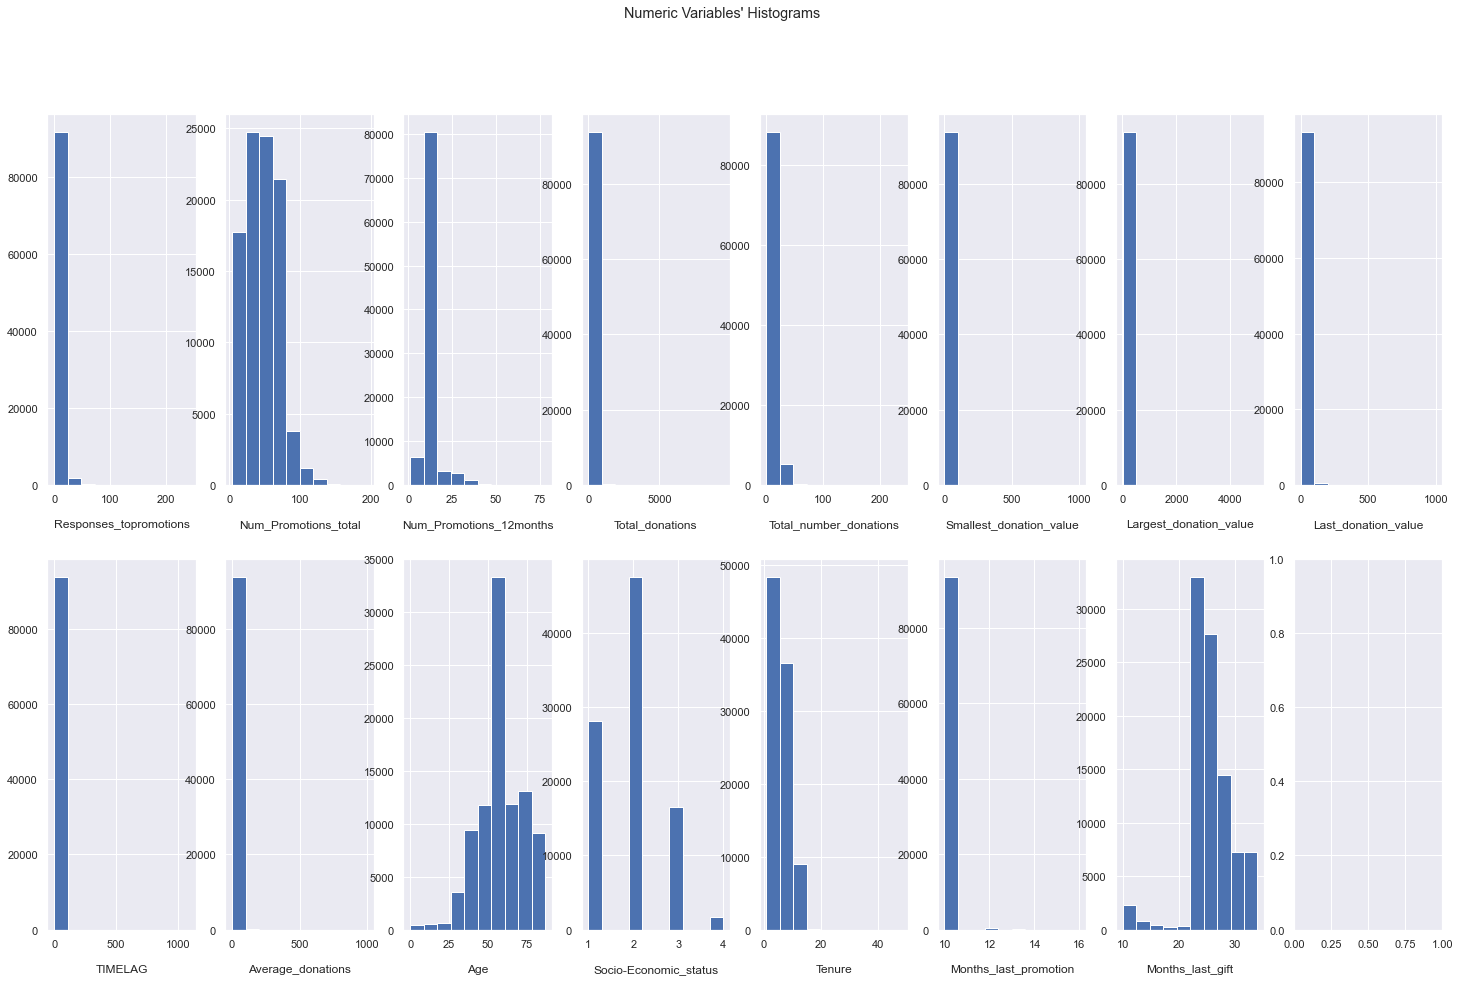

In [67]:
from math import ceil
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric) / 2), figsize=(25, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric): # Notice the zip() function and flatten() method
    ax.hist(data[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)


plt.show()

### Numeric Variables' Box Plots

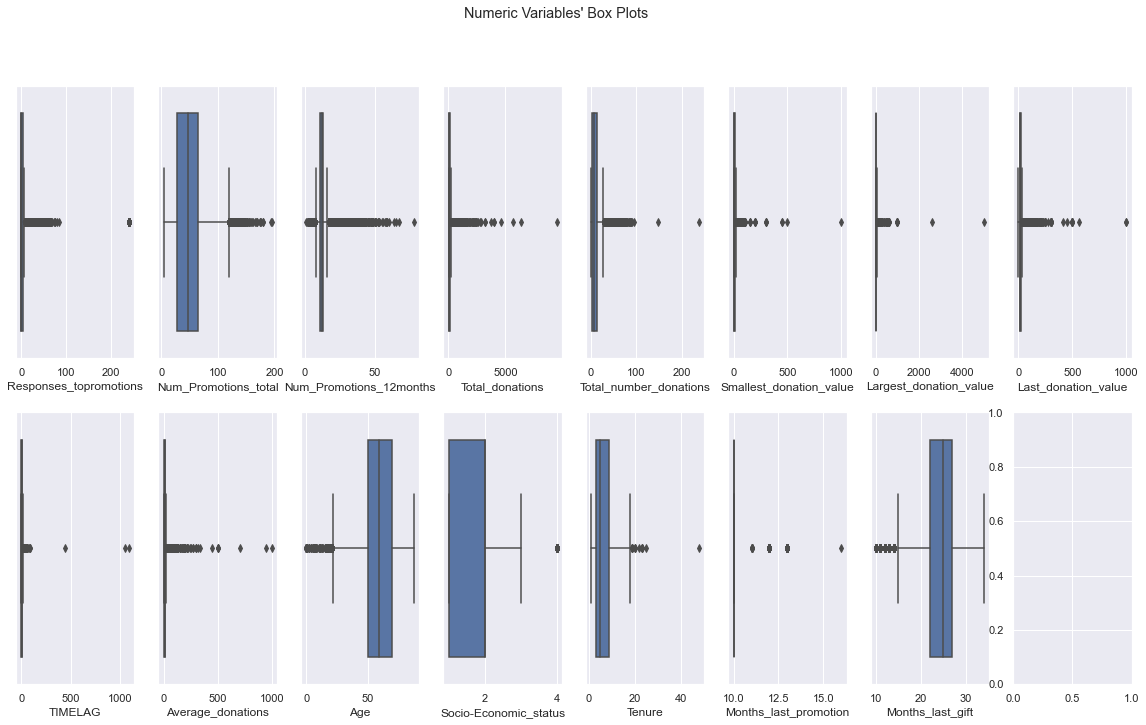

In [68]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric): # Notice the zip() function and flatten() method
    sns.boxplot(data[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

### Responses_topromotions

[Text(0.5, 0, '')]

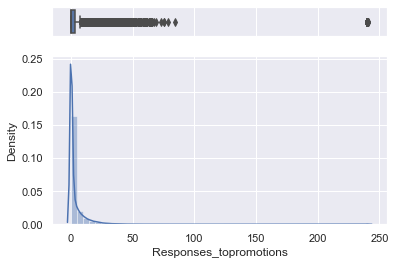

In [69]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Responses_topromotions"], ax=ax_box)
sns.distplot(data["Responses_topromotions"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [70]:
#DROP ABOVE  50

data_to_drop = data[(data["Responses_topromotions"]>50)]

data_to_drop_percent = ((len(data_to_drop.index))/(len(data.index)))*100
data_to_drop_percent = "{:.2f}".format(data_to_drop_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop_percent}% \n")

data.drop(data_to_drop.index, inplace=True)


 Number of records dropped = 	 184 


 Percentage of records dropped = 	0.20% 



### Num_Promotions_total

[Text(0.5, 0, '')]

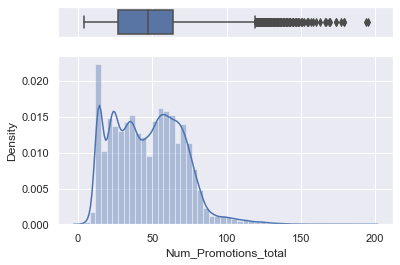

In [71]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Num_Promotions_total"], ax=ax_box)
sns.distplot(data["Num_Promotions_total"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [72]:
#DROP ABOVE 125

data_to_drop1 = data[(data["Num_Promotions_total"]>125)]

data_to_drop1_percent = ((len(data_to_drop1.index))/(len(data.index)))*100
data_to_drop1_percent = "{:.2f}".format(data_to_drop1_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop1.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop1_percent}% \n")

data.drop(data_to_drop1.index, inplace=True)


 Number of records dropped = 	 249 


 Percentage of records dropped = 	0.27% 



### Num_Promotions_12months

[Text(0.5, 0, '')]

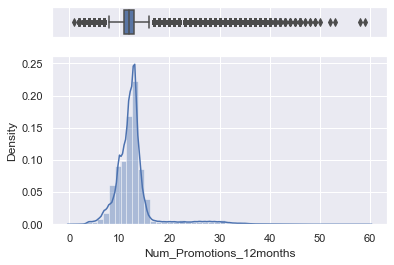

In [73]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Num_Promotions_12months"], ax=ax_box)
sns.distplot(data["Num_Promotions_12months"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [74]:
#DROP ABOVE 55 and BELOW 5 

data_to_drop2= data[(data["Num_Promotions_12months"]<5)| (data["Num_Promotions_12months"]>50)]

data_to_drop2_percent = ((len(data_to_drop2.index))/(len(data.index)))*100
data_to_drop2_percent = "{:.2f}".format(data_to_drop2_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop2.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop2_percent}% \n")

data.drop(data_to_drop2.index, inplace=True)


 Number of records dropped = 	 449 


 Percentage of records dropped = 	0.48% 



### Total_donations

[Text(0.5, 0, '')]

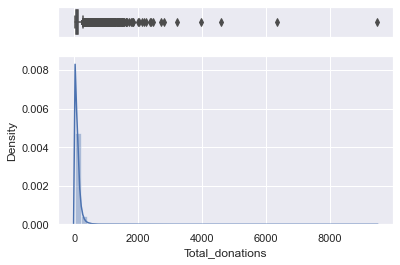

In [75]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Total_donations"], ax=ax_box)
sns.distplot(data["Total_donations"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [76]:
#DROP ABOVE 500 

data_to_drop3 = data[(data["Total_donations"]>500)]

data_to_drop3_percent = ((len(data_to_drop3.index))/(len(data.index)))*100
data_to_drop3_percent = "{:.2f}".format(data_to_drop3_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop3.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop3_percent}% \n")

data.drop(data_to_drop3.index, inplace=True)


 Number of records dropped = 	 771 


 Percentage of records dropped = 	0.83% 



### Total_number_donations

[Text(0.5, 0, '')]

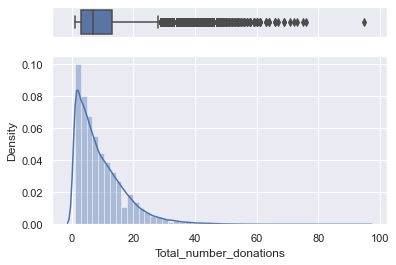

In [77]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Total_number_donations"], ax=ax_box)
sns.distplot(data["Total_number_donations"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [78]:
#DROP ABOVE 35

data_to_drop4= data[(data["Total_number_donations"]>35)]

data_to_drop4_percent = ((len(data_to_drop4.index))/(len(data.index)))*100
data_to_drop4_percent = "{:.2f}".format(data_to_drop4_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop4.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop4_percent}% \n")

data.drop(data_to_drop4.index, inplace=True)



 Number of records dropped = 	 1158 


 Percentage of records dropped = 	1.26% 



### Smallest_donation_value

[Text(0.5, 0, '')]

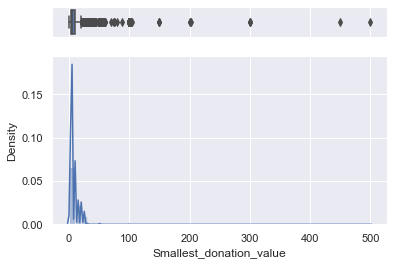

In [79]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Smallest_donation_value"], ax=ax_box)
sns.distplot(data["Smallest_donation_value"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [80]:
#DROP ABOVE 40

data_to_drop5 = data[(data["Smallest_donation_value"]>40)]

data_to_drop5_percent = ((len(data_to_drop5.index))/(len(data.index)))*100
data_to_drop5_percent = "{:.2f}".format(data_to_drop5_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop5.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop5_percent}% \n")

data.drop(data_to_drop5.index, inplace=True)


 Number of records dropped = 	 485 


 Percentage of records dropped = 	0.53% 



### Largest_donation_value

[Text(0.5, 0, '')]

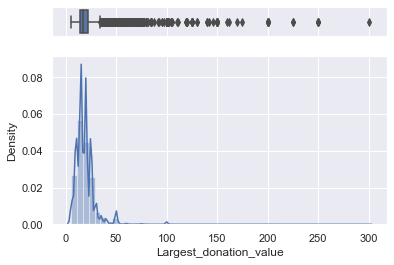

In [81]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Largest_donation_value"], ax=ax_box)
sns.distplot(data["Largest_donation_value"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [82]:
#DROP ABOVE 100

data_to_drop6 = data[(data["Largest_donation_value"]>100)]

data_to_drop6_percent = ((len(data_to_drop6.index))/(len(data.index)))*100
data_to_drop6_percent = "{:.2f}".format(data_to_drop6_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop6.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop6_percent}% \n")

data.drop(data_to_drop6.index, inplace=True)


 Number of records dropped = 	 56 


 Percentage of records dropped = 	0.06% 



### Last_donation_value

[Text(0.5, 0, '')]

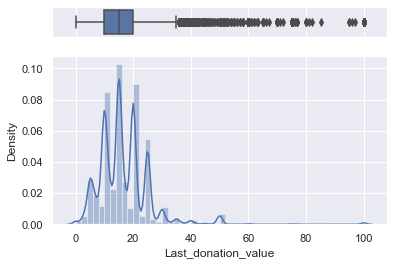

In [83]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Last_donation_value"], ax=ax_box)
sns.distplot(data["Last_donation_value"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [84]:
#DROP ABOVE 50

data_to_drop7= data[(data["Last_donation_value"]>50)]

data_to_drop7_percent = ((len(data_to_drop7.index))/(len(data.index)))*100
data_to_drop7_percent = "{:.2f}".format(data_to_drop7_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop7.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop7_percent}% \n")

data.drop(data_to_drop7.index, inplace=True)


 Number of records dropped = 	 415 


 Percentage of records dropped = 	0.46% 



### TIMELAG

[Text(0.5, 0, '')]

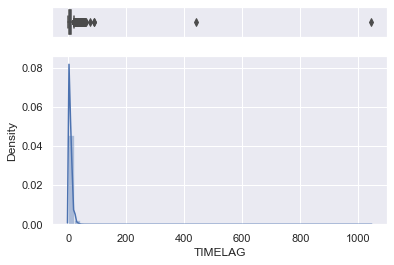

In [85]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["TIMELAG"], ax=ax_box)
sns.distplot(data["TIMELAG"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [86]:
#DROP ABOVE 40

data_to_drop8 = data[(data["TIMELAG"]>40)]

data_to_drop8_percent = ((len(data_to_drop8.index))/(len(data.index)))*100
data_to_drop8_percent = "{:.2f}".format(data_to_drop8_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop8.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop8_percent}% \n")

data.drop(data_to_drop8.index, inplace=True)


 Number of records dropped = 	 121 


 Percentage of records dropped = 	0.13% 



### Average_donations

[Text(0.5, 0, '')]

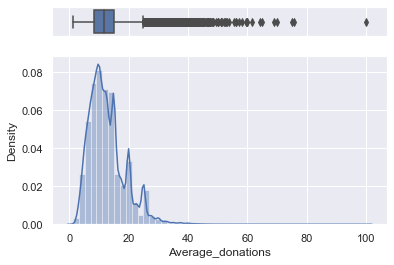

In [87]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Average_donations"], ax=ax_box)
sns.distplot(data["Average_donations"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [88]:
#DROP ABOVE 30

data_to_drop9= data[(data["Average_donations"]>30)]

data_to_drop9_percent = ((len(data_to_drop9.index))/(len(data.index)))*100
data_to_drop9_percent = "{:.2f}".format(data_to_drop9_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop9.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop9_percent}% \n")

data.drop(data_to_drop9.index, inplace=True)


 Number of records dropped = 	 990 


 Percentage of records dropped = 	1.10% 



### Age

[Text(0.5, 0, '')]

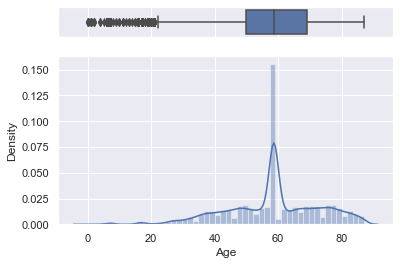

In [89]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Age"], ax=ax_box)
sns.distplot(data["Age"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')


In [90]:
#DROP BELOW 22

data_to_drop10 = data[(data["Age"]<22)]

data_to_drop10_percent= ((len(data_to_drop10.index))/(len(data.index)))*100
data_to_drop10_percent= "{:.2f}".format(data_to_drop10_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop10.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop10_percent}% \n")

data.drop(data_to_drop10.index, inplace=True)


 Number of records dropped = 	 977 


 Percentage of records dropped = 	1.10% 



### Socio-Economic_status

[Text(0.5, 0, '')]

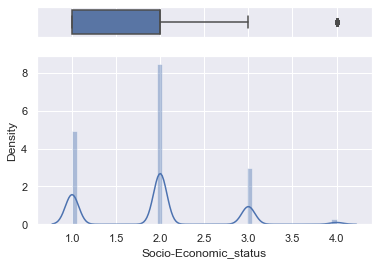

In [91]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Socio-Economic_status"], ax=ax_box)
sns.distplot(data["Socio-Economic_status"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')


### Tenure 

[Text(0.5, 0, '')]

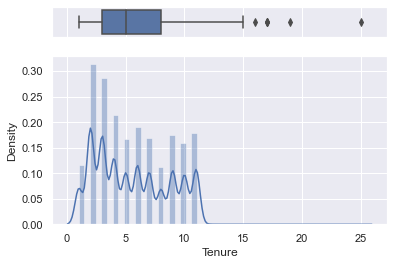

In [92]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Tenure"], ax=ax_box)
sns.distplot(data["Tenure"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')


In [93]:
#DROP ABOVE 15

data_to_drop11 = data[(data["Tenure"]>15)]

data_to_drop11_percent = ((len(data_to_drop11.index))/(len(data.index)))*100
data_to_drop11_percent = "{:.2f}".format(data_to_drop11_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop11.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop11_percent}% \n")

data.drop(data_to_drop11.index, inplace=True)


 Number of records dropped = 	 6 


 Percentage of records dropped = 	0.01% 



### Months_last_promotion

[Text(0.5, 0, '')]

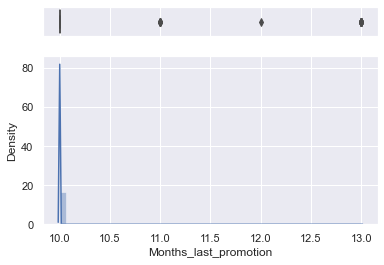

In [94]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Months_last_promotion"], ax=ax_box)
sns.distplot(data["Months_last_promotion"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [95]:
#DROP ABOVE 11 
data_to_drop12 = data[(data["Months_last_promotion"]>=11)]

data_to_drop12_percent = ((len(data_to_drop12.index))/(len(data.index)))*100
data_to_drop12_percent = "{:.2f}".format(data_to_drop12_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop12.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop12_percent}% \n")

data.drop(data_to_drop12.index, inplace=True)



 Number of records dropped = 	 25 


 Percentage of records dropped = 	0.03% 



### Months_last_gift

[Text(0.5, 0, '')]

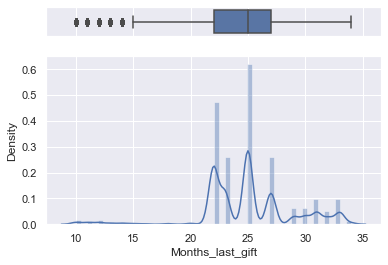

In [96]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["Months_last_gift"], ax=ax_box)
sns.distplot(data["Months_last_gift"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [97]:
#DROP BELOW 15

data_to_drop13 = data[(data["Months_last_gift"]<15)]

data_to_drop13_percent = ((len(data_to_drop13.index))/(len(data.index)))*100
data_to_drop13_percent = "{:.2f}".format(data_to_drop13_percent)

print(f"\n Number of records dropped = \t {len(data_to_drop13.index)} \n")
print(f"\n Percentage of records dropped = \t{data_to_drop13_percent}% \n")

data.drop(data_to_drop13.index, inplace=True)


 Number of records dropped = 	 2595 


 Percentage of records dropped = 	2.95% 



### Non-Metric Variables' Absolute Frequencies

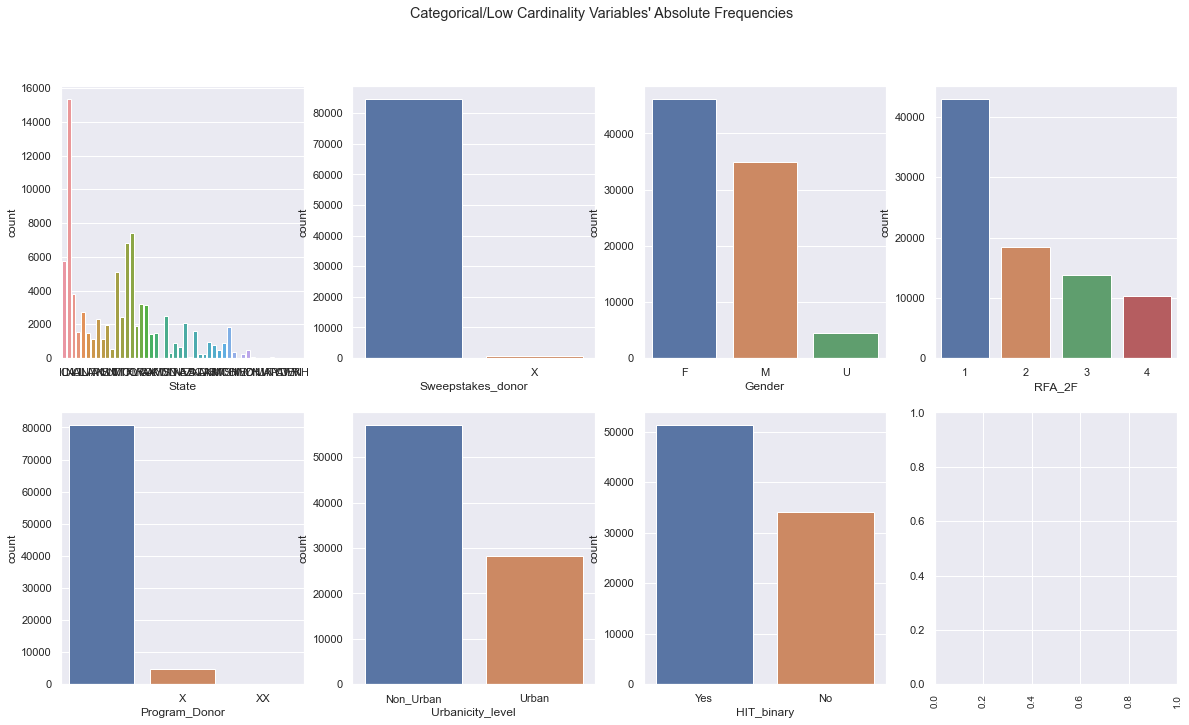

In [98]:
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(new_non_metric) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), new_non_metric): # Notice the zip() function and flatten() method
    sns.countplot(data[feat], ax=ax)
    plt.xticks(fontsize= 10, rotation = 90)

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.show()

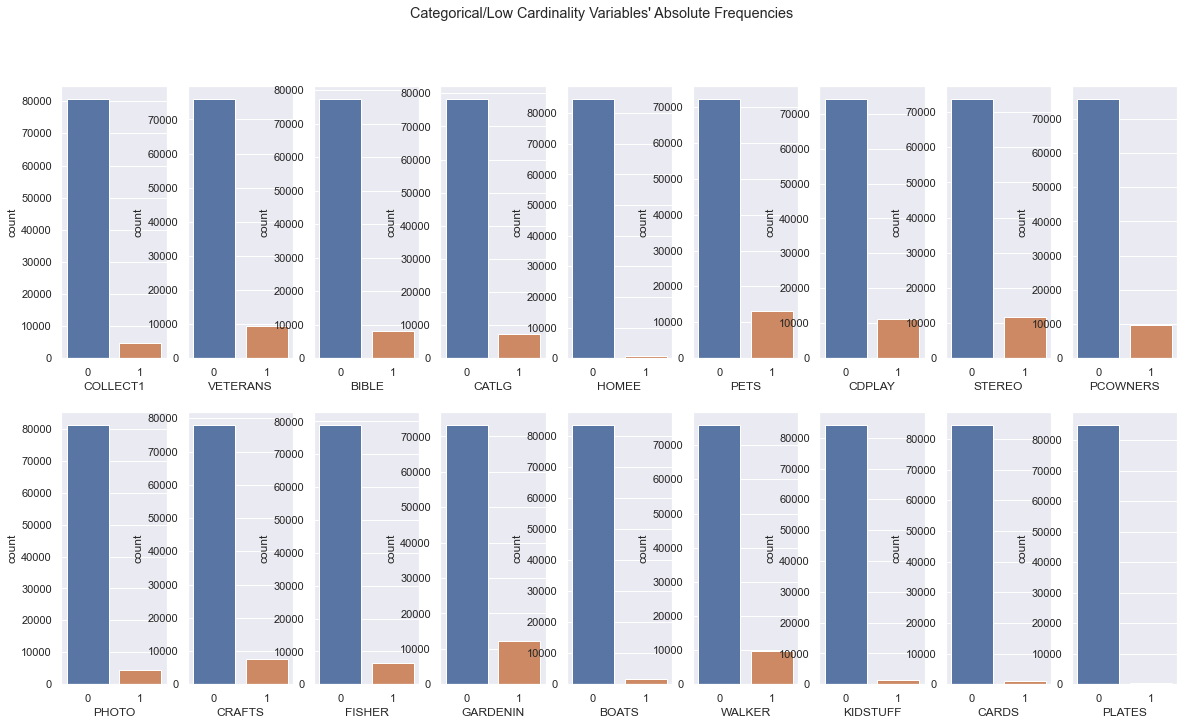

In [99]:
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(preferences) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), preferences): # Notice the zip() function and flatten() method
    sns.countplot(data[feat], ax=ax)

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.show()

## Step 5 - Correlation matrix 

### Correlation matrix for numerical variables 

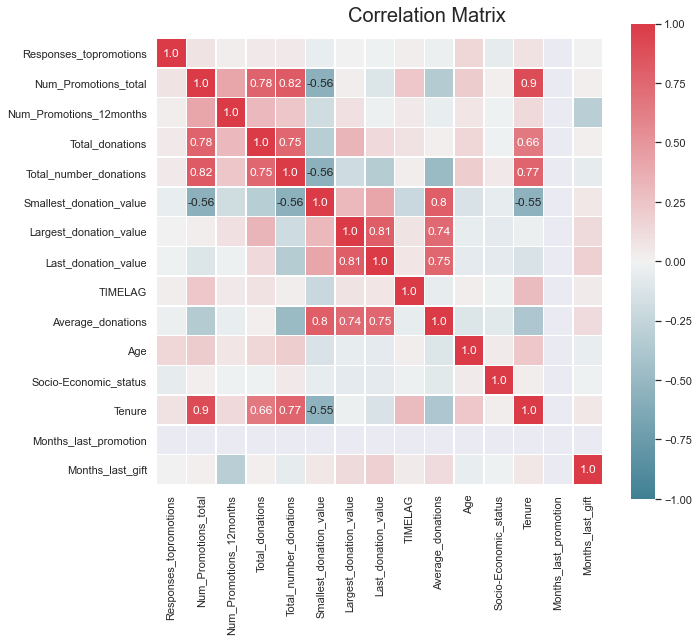

In [100]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data[metric].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [101]:
data[metric].corr(method="pearson")

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_promotion,Months_last_gift
Responses_topromotions,1.000000,0.083336,0.025110,0.052233,0.053340,-0.044828,-0.001102,-0.011561,0.029384,-0.029210,0.146835,-0.059540,0.088025,NaN,-0.003652
Num_Promotions_total,0.083336,1.000000,0.421909,0.775895,0.821479,-0.564768,0.031501,-0.107333,0.234357,-0.339252,0.213972,0.017781,0.899965,NaN,0.015469
Num_Promotions_12months,0.025110,0.421909,1.000000,0.305989,0.237759,-0.175368,0.098615,-0.019132,0.046755,-0.040195,0.071605,-0.006050,0.139913,NaN,-0.314944
Total_donations,0.052233,0.775895,0.305989,1.000000,0.750215,-0.317190,0.329026,0.135128,0.087255,0.016572,0.152773,-0.007771,0.662397,NaN,0.023954
Total_number_donations,0.053340,0.821479,0.237759,0.750215,1.000000,-0.555458,-0.186583,-0.327577,0.032793,-0.494222,0.200926,0.050771,0.772537,NaN,-0.059843
Smallest_donation_value,-0.044828,-0.564768,-0.175368,-0.317190,-0.555458,1.000000,0.315740,0.422532,-0.215838,0.798305,-0.128551,-0.052158,-0.550206,NaN,0.056665
Largest_donation_value,-0.001102,0.031501,0.098615,0.329026,-0.186583,0.315740,1.000000,0.807913,0.075625,0.735781,-0.046591,-0.066272,-0.027076,NaN,0.125649
Last_donation_value,-0.011561,-0.107333,-0.019132,0.135128,-0.327577,0.422532,0.807913,1.000000,0.066797,0.751807,-0.069950,-0.067348,-0.127791,NaN,0.178393
TIMELAG,0.029384,0.234357,0.046755,0.087255,0.032793,-0.215838,0.075625,0.066797,1.000000,-0.054190,0.033045,-0.017784,0.285306,NaN,0.044062
Average_donations,-0.029210,-0.339252,-0.040195,0.016572,-0.494222,0.798305,0.735781,0.751807,-0.054190,1.000000,-0.110841,-0.083675,-0.379760,NaN,0.120347


In [102]:
#no correlation between Months_last_promotion and other variables
data.drop(columns=['Months_last_promotion'], inplace=True)

In [103]:
metric.remove('Months_last_promotion')

# Data Normalization

In [104]:
data_normalized = data.copy()

In [105]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_normalized[metric])
data_normalized[metric] = scaled_data
data_normalized[metric].head()

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_gift
CONTROLN,,,,,,,,,,,,,,
95515,0.00,0.571429,0.200000,0.466119,0.882353,0.166667,0.073684,0.2,0.100,0.224844,0.584615,0.333333,0.500000,0.526316
148535,0.32,0.218487,0.177778,0.069815,0.058824,0.333333,0.210526,0.5,0.450,0.500829,0.353846,0.000000,0.214286,0.526316
15078,0.04,0.478992,0.200000,0.388090,0.764706,0.066667,0.115789,0.1,0.300,0.215773,0.564026,0.333333,0.428571,0.526316
172556,0.04,0.504202,0.200000,0.197125,0.441176,0.066667,0.063158,0.2,0.225,0.192475,0.723077,0.333333,0.642857,0.526316
47784,0.00,0.243697,0.155556,0.078029,0.088235,0.333333,0.115789,0.3,0.150,0.399254,0.564026,0.333333,0.142857,0.842105


# One hot encoding

In [106]:
#One hot encoding of categorical variables

ohc = OneHotEncoder(sparse=False, drop= 'if_binary')
ohc_feat = ohc.fit_transform(data[new_non_metric])
ohc_feat_names = ohc.get_feature_names(new_non_metric)
ohc_df = pd.DataFrame(ohc_feat, index=data.index, columns=ohc_feat_names) 
df_ohc = pd.concat([data_normalized.drop(columns=new_non_metric), ohc_df], axis=1)
df_ohc

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,...,Gender_U,RFA_2F_1,RFA_2F_2,RFA_2F_3,RFA_2F_4,Program_Donor_,Program_Donor_X,Program_Donor_XX,Urbanicity_level_Urban,HIT_binary_Yes
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,0.00,0.571429,0.200000,0.466119,0.882353,0.166667,0.073684,0.20,0.100,0.224844,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
148535,0.32,0.218487,0.177778,0.069815,0.058824,0.333333,0.210526,0.50,0.450,0.500829,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15078,0.04,0.478992,0.200000,0.388090,0.764706,0.066667,0.115789,0.10,0.300,0.215773,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
172556,0.04,0.504202,0.200000,0.197125,0.441176,0.066667,0.063158,0.20,0.225,0.192475,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
47784,0.00,0.243697,0.155556,0.078029,0.088235,0.333333,0.115789,0.30,0.150,0.399254,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58178,0.00,0.268908,0.155556,0.094456,0.264706,0.100000,0.063158,0.16,0.075,0.160697,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
156106,0.00,0.285714,0.177778,0.137577,0.058824,0.833333,0.263158,0.50,0.475,0.883914,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
35088,0.20,0.445378,0.155556,0.139630,0.676471,0.066667,0.042105,0.04,0.075,0.072761,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


# PCA

In [107]:
data_pca = data_normalized[metric].copy()

In [108]:
pca = PCA()
pca_metrics = pca.fit_transform(data_pca)

In [109]:
# Obtaining the projected observations on the principal components axes (linear combinations)
data_pca_clusters = pd.DataFrame(data_pca[metric].values @ pca.components_.T, index=data_pca.index,
             columns=[f"PC{i}" for i in range(pca.n_components_)])
data_pca_clusters

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
CONTROLN,,,,,,,,,,,,,,
95515,0.942891,0.553224,0.894869,-0.247505,-0.189388,-0.370943,-0.059328,-0.220312,0.324044,0.047749,-0.269198,0.089925,-0.018531,-0.071733
148535,-0.038690,0.767923,0.657015,-0.201079,-0.455473,0.213662,0.259696,-0.086055,0.130793,0.110619,-0.250183,0.097265,0.018931,-0.062934
15078,0.867017,0.454597,0.805757,-0.240672,-0.301351,-0.164353,-0.025656,-0.223310,0.397185,0.058027,-0.187318,0.161772,-0.001791,-0.066869
172556,0.802716,0.444613,0.821182,-0.409192,-0.428586,-0.070889,-0.028571,-0.181016,0.004682,0.172673,-0.182526,0.099911,0.006087,-0.101811
47784,0.026956,0.433511,0.863680,-0.316111,-0.663654,-0.209928,-0.052624,-0.128465,0.144251,0.227302,-0.189307,0.061734,-0.006581,-0.046866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58178,0.332252,0.223034,0.652060,-0.228985,-0.483722,-0.224498,-0.046553,-0.067750,0.131069,0.162860,-0.180558,0.086725,0.001981,-0.052455
156106,-0.261123,0.681068,1.514905,-0.293625,-0.495072,0.073781,-0.008313,-0.446695,0.191907,0.223223,-0.211602,0.107985,-0.013777,-0.032476
35088,0.775765,0.232874,0.612169,-0.195234,-0.180658,-0.244085,0.171503,-0.198893,0.152146,0.072272,-0.248479,0.191229,-0.052392,-0.044103


In [110]:
# Output PCA table
pd.DataFrame(
   {"Eigenvalue": pca.explained_variance_,
    "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
    "Proportion": pca.explained_variance_ratio_,
    "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1))

,Eigenvalue,Difference,Proportion,Cumulative
1,0.159125,0.000000,0.367154,0.367154
2,0.064474,-0.094651,0.148764,0.515918
3,0.057142,-0.007333,0.131845,0.647763
4,0.042113,-0.015029,0.097168,0.744931
5,0.032030,-0.010083,0.073903,0.818834
6,0.026249,-0.005781,0.060565,0.879398
7,0.014821,-0.011428,0.034197,0.913596
8,0.014327,-0.000494,0.033058,0.946654
9,0.009429,-0.004898,0.021756,0.968410
10,0.006056,-0.003373,0.013974,0.982384


In [111]:
np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95)

8

In [112]:
pca_feat_names = [f"PC{i}" for i in range(np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95))]

In [113]:
#pca_90_pct = pd.DataFrame(pca_metrics[:,0:9], index= data_pca[metric].index, columns = pca_feat_names) 
#plt.scatter(pca_90_pct['PC0'], pca_90_pct['PC8'])

In [114]:
#Cant use density clustering because it wont distinguish the clusters. 

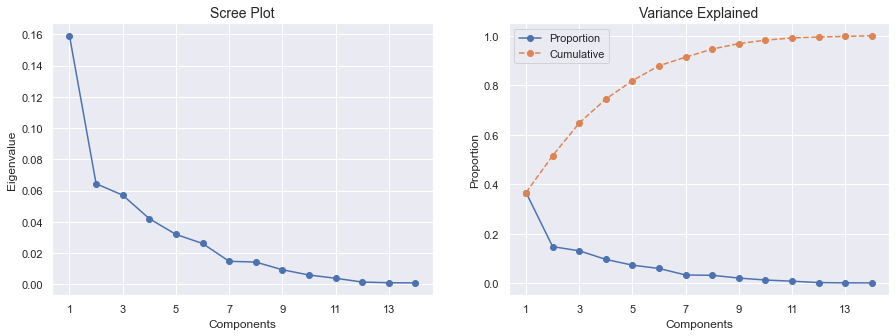

In [115]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")
# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))
plt.show()

# Clustering

## Kmeans Clustering

### Kmeans with normalized numerical data 

#### Defining the number of clusters:

In [116]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data_normalized[metric])
    inertia.append(kmclust.inertia_)

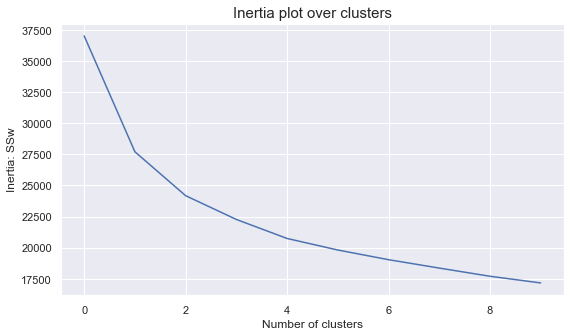

In [117]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.22268168331919974
For n_clusters = 3, the average silhouette_score is : 0.18097263335038383
For n_clusters = 4, the average silhouette_score is : 0.17424244349707732
For n_clusters = 5, the average silhouette_score is : 0.16896895823613187
For n_clusters = 6, the average silhouette_score is : 0.1450063688444441
For n_clusters = 7, the average silhouette_score is : 0.13293817180764533
For n_clusters = 8, the average silhouette_score is : 0.13072613804684757
For n_clusters = 9, the average silhouette_score is : 0.13369529561677423
For n_clusters = 10, the average silhouette_score is : 0.13266494705272244


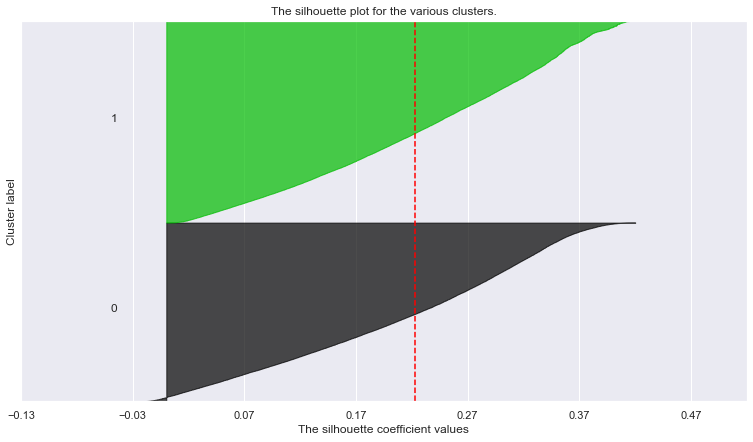

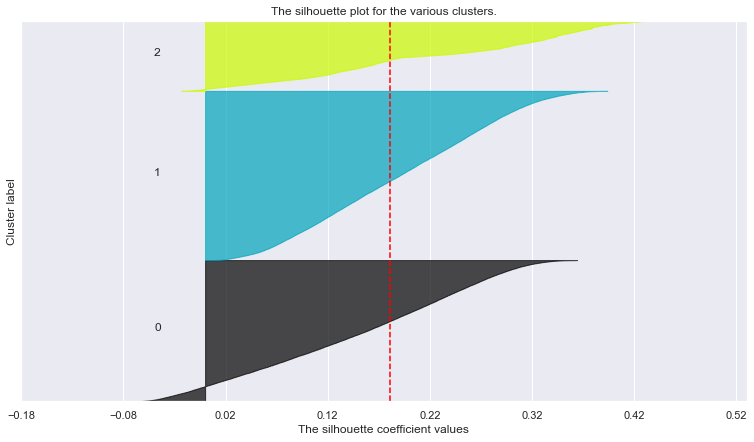

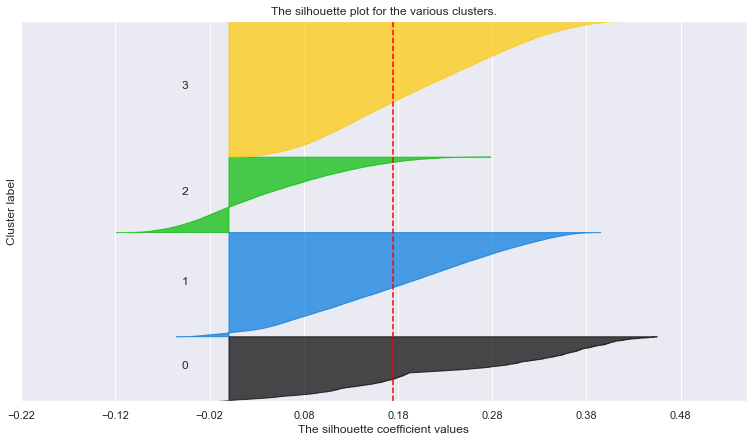

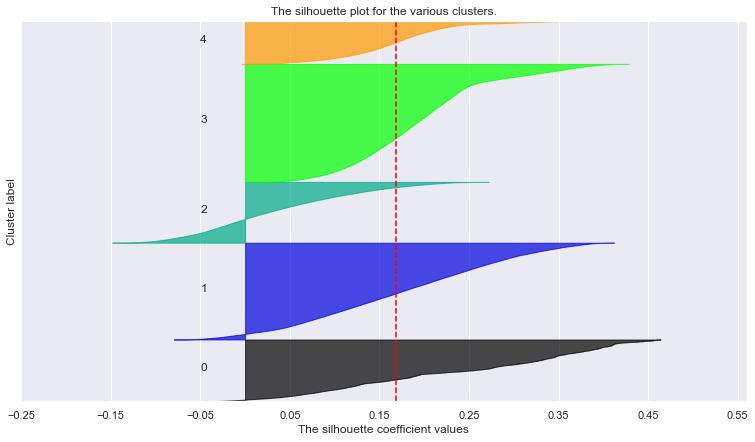

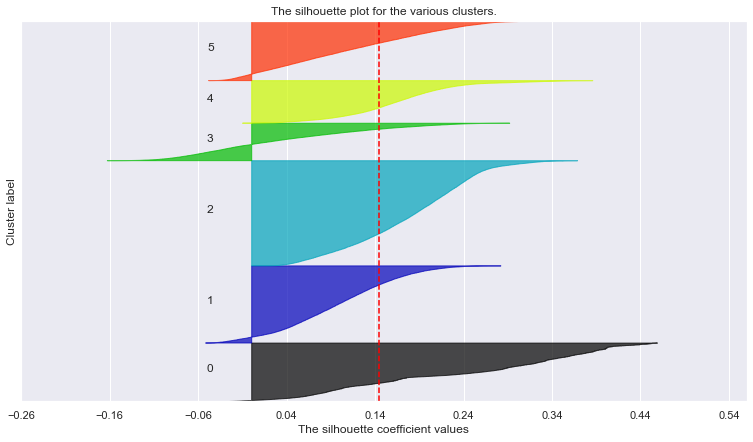

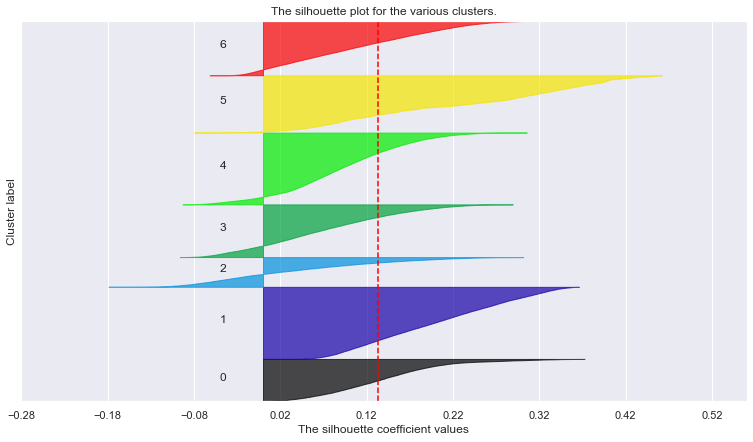

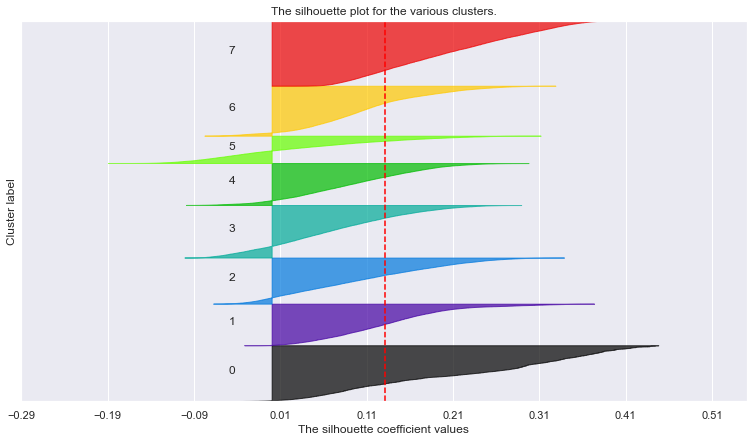

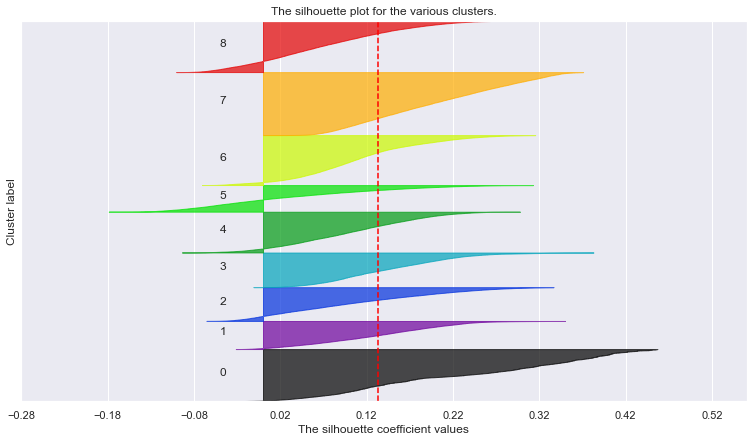

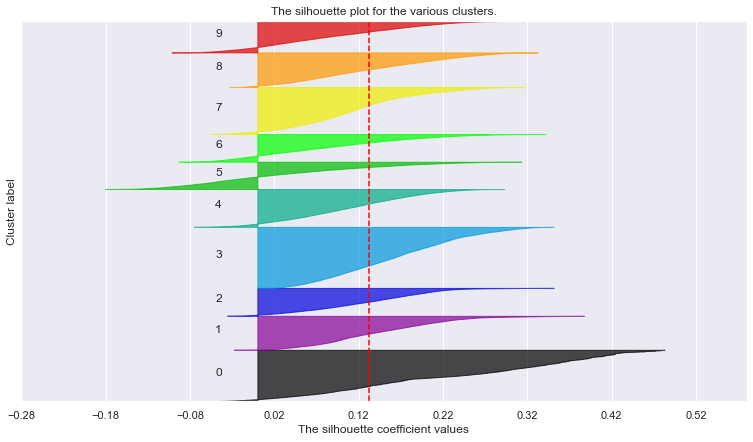

In [118]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(data_normalized[metric])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(data_normalized[metric], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_normalized[metric], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(data_normalized[metric]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

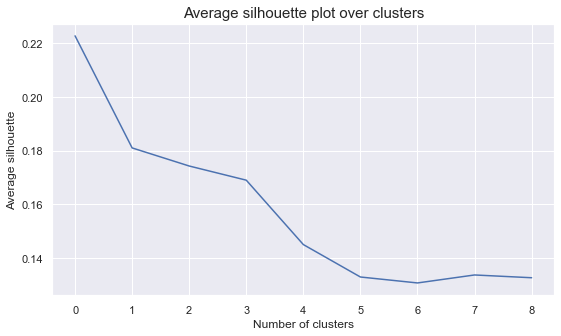

In [119]:
# The average silhouette plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

#### Cluster solution

In [118]:
#Having run the kmeans and Silhouette analysis, although the elbow and scores of silhouette suggest 2, 
#we decided to work with 3 clusters. 
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(data_normalized[metric])
km_labels

array([0, 1, 0, ..., 0, 2, 2])

In [119]:
data_normalized[metric]

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_gift
CONTROLN,,,,,,,,,,,,,,
95515,0.00,0.571429,0.200000,0.466119,0.882353,0.166667,0.073684,0.20,0.100,0.224844,0.584615,0.333333,0.500000,0.526316
148535,0.32,0.218487,0.177778,0.069815,0.058824,0.333333,0.210526,0.50,0.450,0.500829,0.353846,0.000000,0.214286,0.526316
15078,0.04,0.478992,0.200000,0.388090,0.764706,0.066667,0.115789,0.10,0.300,0.215773,0.564026,0.333333,0.428571,0.526316
172556,0.04,0.504202,0.200000,0.197125,0.441176,0.066667,0.063158,0.20,0.225,0.192475,0.723077,0.333333,0.642857,0.526316
47784,0.00,0.243697,0.155556,0.078029,0.088235,0.333333,0.115789,0.30,0.150,0.399254,0.564026,0.333333,0.142857,0.842105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58178,0.00,0.268908,0.155556,0.094456,0.264706,0.100000,0.063158,0.16,0.075,0.160697,0.461538,0.333333,0.214286,0.631579
156106,0.00,0.285714,0.177778,0.137577,0.058824,0.833333,0.263158,0.50,0.475,0.883914,0.564026,0.666667,0.214286,0.736842
35088,0.20,0.445378,0.155556,0.139630,0.676471,0.066667,0.042105,0.04,0.075,0.072761,0.415385,0.333333,0.428571,0.368421


In [120]:
# Characterizing the final clusters with the standardized numerical data
km_normalized = pd.concat((data_normalized[metric], pd.Series(km_labels, name='labels')), axis=1)
km_norm_labeled = km_normalized.groupby('labels').mean()
km_norm_labeled['Labels_2'] = km_norm_labeled.index 
km_norm_labeled

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_gift,Labels_2
labels,,,,,,,,,,,,,,,
0.0,0.061834,0.350940,0.179249,0.167924,0.247640,0.241263,0.137643,0.317700,0.177404,0.379001,0.571906,0.335963,0.340577,0.543301,0.0
1.0,0.063956,0.348519,0.177787,0.166442,0.244031,0.242422,0.138495,0.318976,0.177703,0.380021,0.566886,0.333432,0.338621,0.543446,1.0
2.0,0.061555,0.347551,0.177003,0.164759,0.245211,0.240978,0.137427,0.317732,0.177890,0.377439,0.569716,0.335009,0.339331,0.545735,2.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Responses_topromotions'),
  Text(1, 0, 'Num_Promotions_total'),
  Text(2, 0, 'Num_Promotions_12months'),
  Text(3, 0, 'Total_donations'),
  Text(4, 0, 'Total_number_donations'),
  Text(5, 0, 'Smallest_donation_value'),
  Text(6, 0, 'Largest_donation_value'),
  Text(7, 0, 'Last_donation_value'),
  Text(8, 0, 'TIMELAG'),
  Text(9, 0, 'Average_donations'),
  Text(10, 0, 'Age'),
  Text(11, 0, 'Socio-Economic_status'),
  Text(12, 0, 'Tenure'),
  Text(13, 0, 'Months_last_gift')])

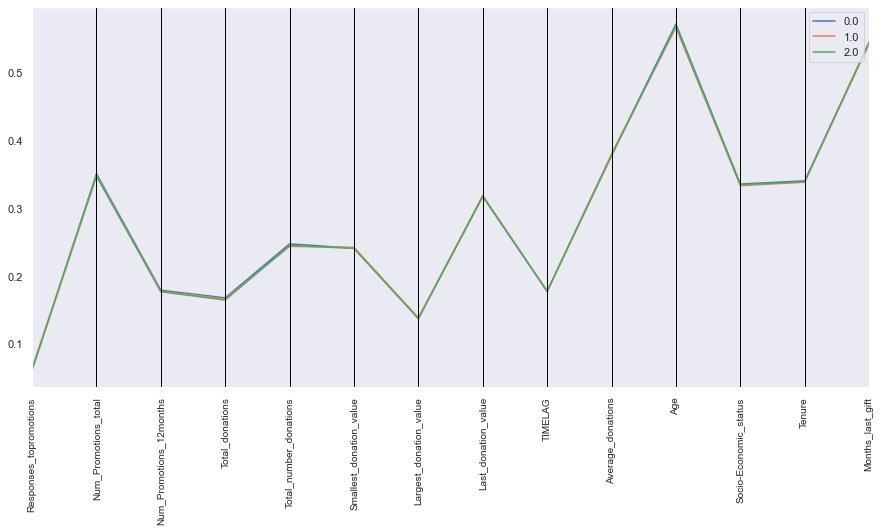

In [121]:

plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(km_norm_labeled, class_column = 'Labels_2', color=sns.color_palette())
plt.xticks(fontsize=10, rotation=90)

### Kmeans with raw numerical data 

In [122]:
#characterizing the final clusters with raw numerical data
km_initial_num = pd.concat((data[metric], pd.Series(km_labels, name='labels')), axis=1)
km_initial_num=km_initial_num.groupby('labels').mean()
km_initial_num['Labels_2'] = km_initial_num.index
km_initial_num


,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_gift,Labels_2
labels,,,,,,,,,,,,,,,
0.0,3.091724,47.761833,13.066193,94.779132,9.419750,7.237895,18.076122,15.885010,7.096170,12.168452,59.173917,2.007889,5.768072,25.322719,0.0
1.0,3.197816,47.473737,13.000415,94.057416,9.297050,7.272650,18.157057,15.948808,7.108137,12.197735,58.847562,2.000297,5.740697,25.325479,1.0
2.0,3.077753,47.358610,12.965115,93.237775,9.337177,7.229341,18.055561,15.886616,7.115595,12.123593,59.031549,2.005026,5.750628,25.368958,2.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Responses_topromotions'),
  Text(1, 0, 'Num_Promotions_total'),
  Text(2, 0, 'Num_Promotions_12months'),
  Text(3, 0, 'Total_donations'),
  Text(4, 0, 'Total_number_donations'),
  Text(5, 0, 'Smallest_donation_value'),
  Text(6, 0, 'Largest_donation_value'),
  Text(7, 0, 'Last_donation_value'),
  Text(8, 0, 'TIMELAG'),
  Text(9, 0, 'Average_donations'),
  Text(10, 0, 'Age'),
  Text(11, 0, 'Socio-Economic_status'),
  Text(12, 0, 'Tenure'),
  Text(13, 0, 'Months_last_gift')])

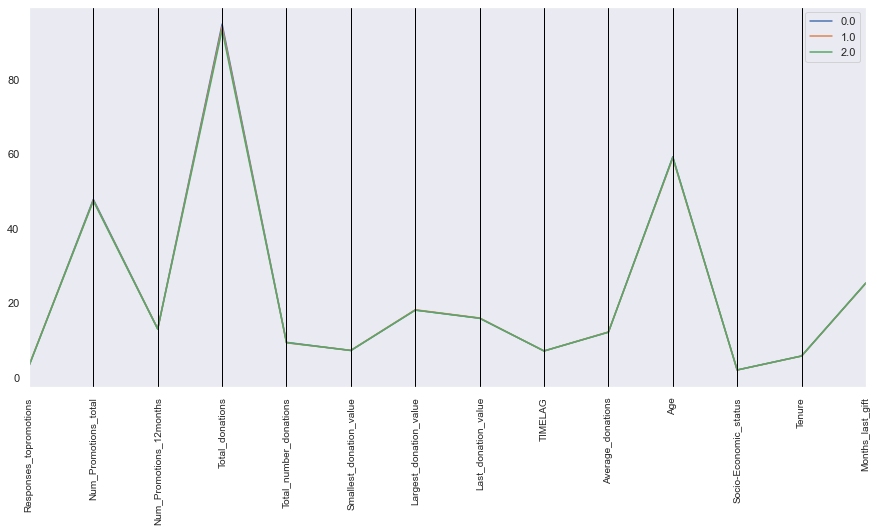

In [123]:

#plot each cluster x= variables, y= standardized values, line chart (line per cluster). 
plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(km_initial_num, class_column = 'Labels_2', color=sns.color_palette())
plt.xticks(fontsize=10, rotation=90)

### Kmeans with encoded data

In [124]:
#characterizing the final clusters with encoded data
km_encoded= pd.concat((ohc_df, pd.Series(km_labels, name='labels')), axis=1)
km_encoded=km_encoded.groupby('labels').mean()
km_encoded

,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DE,State_FL,State_GA,...,Gender_U,RFA_2F_1,RFA_2F_2,RFA_2F_3,RFA_2F_4,Program_Donor_,Program_Donor_X,Program_Donor_XX,Urbanicity_level_Urban,HIT_binary_Yes
labels,,,,,,,,,,,,,,,,,,,,,
0.0,0.000430,0.039874,0.002008,0.004159,0.025531,0.003586,0.000502,0.000072,0.190476,0.084481,...,0.045468,0.483505,0.227051,0.165232,0.124211,0.894865,0.103701,0.001434,0.290017,0.575086
1.0,0.000297,0.040537,0.001602,0.004392,0.025699,0.002968,0.000119,0.000000,0.184937,0.080480,...,0.046234,0.501751,0.213544,0.161375,0.123331,0.897620,0.100837,0.001543,0.280907,0.575405
2.0,0.000443,0.039911,0.001626,0.003843,0.026016,0.004730,0.000443,0.000000,0.192461,0.076718,...,0.044642,0.496231,0.213008,0.167332,0.123429,0.896526,0.101848,0.001626,0.292535,0.568958


### Kmeans with PCA dataframe

#### Defining the number of clusters:

In [125]:
range_clusters = range(1, 11)
inertia_pca = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(data_pca_clusters)
    inertia_pca.append(kmclust.inertia_)  # save the inertia of the given cluster solution

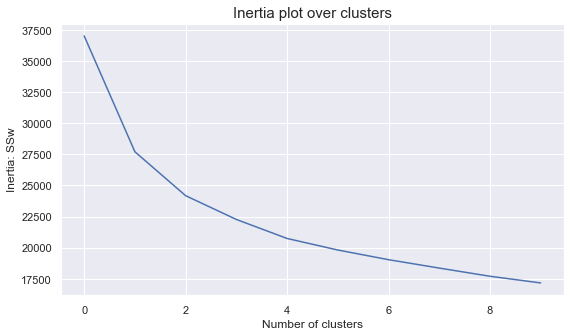

In [126]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia_pca)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

## Hierarchical and Kmean 

### Defining Kmeans clusters as centroids.

In [127]:
#Run Kmeans with 50 n_clusters 
kmclust_hier = KMeans(n_clusters= 50, init='k-means++', n_init=15, random_state=1)

In [128]:
km_labels_hier = kmclust_hier.fit_predict(data_normalized[metric])
km_labels_hier

array([14, 22, 14, ..., 45,  7, 10])

#### On normalized numerical data

In [129]:
#Assign cluster labels to normalized data
km_hier_normalized = pd.concat((data_normalized[metric], pd.Series(km_labels_hier, name='Km_Label', 
                                                                   index=data_normalized[metric].index.tolist())), 
                               axis=1)
km_hier_normalized = km_hier_normalized.groupby('Km_Label').mean()
km_hier_normalized

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_gift
Km_Label,,,,,,,,,,,,,,
0,0.059004,0.506300,0.180698,0.271697,0.461923,0.126588,0.114702,0.250575,0.178613,0.267890,0.232003,0.358460,0.538728,0.520710
1,0.072416,0.479468,0.169176,0.217996,0.384847,0.130386,0.104060,0.249339,0.189337,0.261075,0.839994,0.000000,0.554699,0.488763
2,0.027505,0.188869,0.155166,0.063908,0.067084,0.266182,0.150685,0.368964,0.234550,0.426612,0.493252,0.333333,0.144519,0.488288
3,0.055368,0.315059,0.151253,0.118464,0.106481,0.287674,0.175559,0.404495,0.661427,0.486829,0.505157,0.197165,0.361482,0.630820
4,0.053525,0.476653,0.183241,0.357773,0.283532,0.241618,0.270447,0.525232,0.225394,0.581616,0.634333,0.703154,0.487411,0.560932
5,0.074835,0.455775,0.165362,0.190250,0.342461,0.134264,0.101728,0.254185,0.195325,0.258651,0.840040,0.698784,0.531723,0.500390
6,0.053209,0.524377,0.184170,0.358791,0.345322,0.194298,0.225099,0.450933,0.201167,0.477992,0.711189,0.295021,0.584764,0.499846
7,0.038949,0.081856,0.142126,0.034203,0.008592,0.749401,0.192984,0.462084,0.030556,0.752709,0.572626,0.333153,0.032559,0.445101
8,0.058988,0.530929,0.127774,0.292692,0.516246,0.121709,0.107323,0.253057,0.159364,0.252733,0.700852,0.404544,0.618864,0.876022


In [130]:
km_hier_normalized['Km_Label'] = km_hier_normalized.index

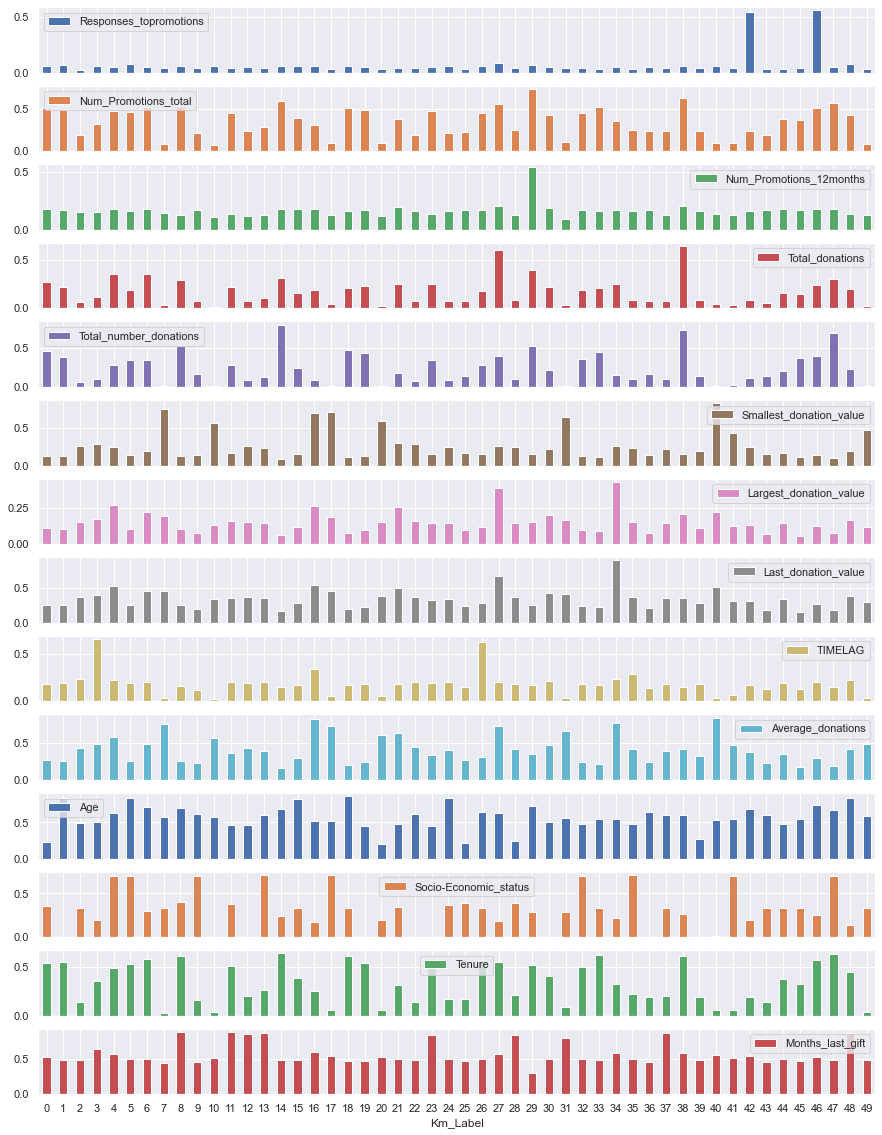

In [131]:
axes = km_hier_normalized.plot.bar(x='Km_Label',y=metric, rot=0, subplots=True, figsize=(15,20), 
                                   title=['','','','','','','','','','','','','',''])
axes[1].legend(loc=2)  

In [132]:
del km_hier_normalized['Km_Label']

In [133]:
km_hier_normalized.columns

Index(['Responses_topromotions', 'Num_Promotions_total',
       'Num_Promotions_12months', 'Total_donations', 'Total_number_donations',
       'Smallest_donation_value', 'Largest_donation_value',
       'Last_donation_value', 'TIMELAG', 'Average_donations', 'Age',
       'Socio-Economic_status', 'Tenure', 'Months_last_gift'],
      dtype='object')

#### On raw  data

In [134]:
km_hier_raw = pd.concat((data[metric], pd.Series(km_labels_hier, name='Km_Label', 
                                                                   index=data[metric].index.tolist())), 
                               axis=1)
km_hier_raw = km_hier_raw.groupby('Km_Label').mean()
km_hier_raw

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_gift
Km_Label,,,,,,,,,,,,,,
0,2.950207,66.249654,13.131397,145.316570,16.705394,3.797649,15.896722,12.528728,7.144537,8.977973,37.080221,2.075380,8.542185,24.893499
1,3.620809,63.056706,12.612919,119.164186,14.084813,3.911588,14.885666,12.466963,7.573471,8.782288,76.599606,1.000000,8.765779,24.286489
2,1.375253,28.475388,11.982468,44.123129,3.280850,7.985452,19.315044,18.448203,9.381996,13.535587,54.061364,2.000000,3.023264,24.277478
3,2.768413,43.492027,11.806378,70.692179,4.620349,8.630220,21.678071,20.224768,26.457099,15.264667,54.835186,1.591496,6.060744,26.985573
4,2.676252,62.721707,13.245826,187.235640,10.640074,7.248534,30.692440,26.261596,9.015770,17.986412,63.231624,3.109462,7.823748,25.657699
5,3.741733,60.237172,12.441277,105.651773,12.643672,4.027913,14.664128,12.709236,7.812999,8.712681,76.602623,3.096351,8.444128,24.507412
6,2.660443,68.400817,13.287631,187.731009,12.740957,5.828944,26.384452,22.546674,8.046674,15.010917,68.227271,1.885064,9.186698,24.497083
7,1.947425,15.740921,11.395664,29.657035,1.292141,22.482016,23.333458,23.104190,1.222222,22.899202,59.220684,1.999458,1.455827,23.456911
8,2.949403,69.180604,10.749824,155.541181,18.552354,3.651265,15.195713,12.652846,6.374561,8.542755,67.555390,2.213633,9.664090,31.644413


In [136]:
km_hier_raw['Km_Label'] = km_hier_raw.index

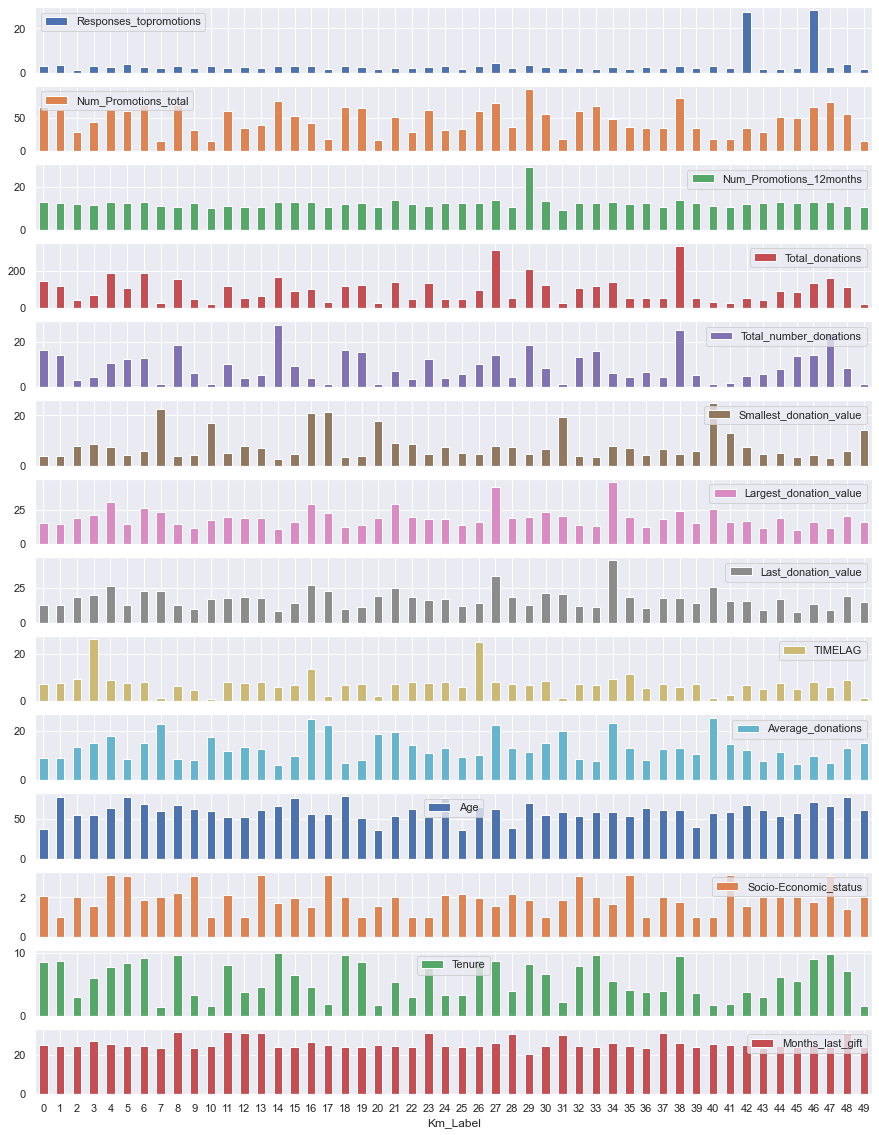

In [137]:
axes2 = km_hier_raw.plot.bar(x='Km_Label',y=metric, rot=0, subplots=True, figsize=(15,20), 
                                   title=['','','','','','','','','','','','','',''])
axes2[1].legend(loc=2) 

In [138]:
del km_hier_raw['Km_Label']

#### On encoded data

In [139]:
km_hier_encoded = pd.concat((ohc_df, pd.Series(km_labels_hier, name='Km_Label', index=ohc_df.index.tolist())), axis=1)
km_hier_encoded = km_hier_encoded.groupby('Km_Label').mean()
km_hier_encoded

,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DE,State_FL,State_GA,...,Gender_U,RFA_2F_1,RFA_2F_2,RFA_2F_3,RFA_2F_4,Program_Donor_,Program_Donor_X,Program_Donor_XX,Urbanicity_level_Urban,HIT_binary_Yes
Km_Label,,,,,,,,,,,,,,,,,,,,,
0,0.001383,0.013140,0.008990,0.020055,0.110650,0.026279,0.000000,0.000000,0.071923,0.031812,...,0.044260,0.340941,0.298064,0.188105,0.172891,0.919779,0.076072,0.004149,0.248271,0.549793
1,0.000493,0.014793,0.002959,0.027120,0.262327,0.025148,0.000000,0.000000,0.102564,0.030079,...,0.053748,0.350099,0.295365,0.230769,0.123767,0.925542,0.073964,0.000493,0.446252,0.444773
2,0.006743,0.022589,0.012812,0.022589,0.131827,0.020229,0.000337,0.000000,0.079906,0.047539,...,0.055293,0.559676,0.306473,0.098449,0.035401,0.982131,0.017532,0.000337,0.219150,0.705327
3,0.004556,0.016705,0.005315,0.027335,0.222475,0.024298,0.000000,0.000000,0.076689,0.042521,...,0.056948,0.755505,0.182232,0.051632,0.010630,0.972665,0.027335,0.000000,0.303721,0.603645
4,0.000000,0.017625,0.015770,0.026902,0.137291,0.012987,0.000000,0.000000,0.103896,0.035250,...,0.062152,0.608534,0.258813,0.085343,0.047310,0.942486,0.057514,0.000000,0.525974,0.650278
5,0.000570,0.012543,0.015964,0.021665,0.110604,0.017674,0.000570,0.000000,0.127138,0.022805,...,0.039339,0.385975,0.302737,0.195553,0.115735,0.949829,0.049601,0.000570,0.537058,0.501140
6,0.001167,0.012252,0.014586,0.026838,0.161610,0.015169,0.000000,0.000583,0.091599,0.033256,...,0.065928,0.554842,0.278880,0.107351,0.058926,0.911902,0.088098,0.000000,0.277130,0.599767
7,0.010840,0.017344,0.014634,0.026016,0.156640,0.013008,0.000000,0.000000,0.081843,0.044986,...,0.048780,0.866125,0.118157,0.013008,0.002710,0.978320,0.021680,0.000000,0.248780,0.688889
8,0.000000,0.021785,0.013352,0.026001,0.123682,0.020379,0.000000,0.000000,0.089248,0.028110,...,0.063247,0.794800,0.152495,0.045678,0.007027,0.900914,0.098384,0.000703,0.286718,0.589599


### Run HClustering with the 50 kmeans clusters

In [140]:
linkage = 'ward'
distance = 'euclidean'
hc = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=None, distance_threshold=0.000001)
hc.fit_predict(km_hier_normalized)

array([35, 36, 46, 28, 29, 42, 45, 40, 49, 43, 22, 38, 44, 26, 32, 39, 41,
       34, 24, 31, 27, 17, 48, 47, 20, 37, 23, 21, 33, 19, 16, 15, 13, 11,
       25, 18, 30, 10,  8,  9,  7,  4,  3, 12,  5, 14,  1,  6,  2,  0],
      dtype=int64)

In [141]:
km_hier_normalized.columns

Index(['Responses_topromotions', 'Num_Promotions_total',
       'Num_Promotions_12months', 'Total_donations', 'Total_number_donations',
       'Smallest_donation_value', 'Largest_donation_value',
       'Last_donation_value', 'TIMELAG', 'Average_donations', 'Age',
       'Socio-Economic_status', 'Tenure', 'Months_last_gift'],
      dtype='object')

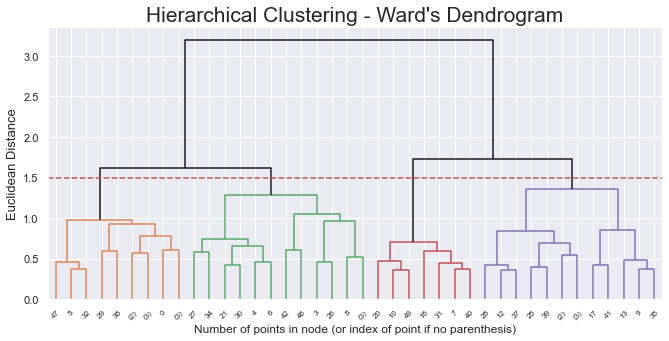

In [142]:

# Create the counts of samples under each node (number of points being merged)
counts = np.zeros(hc.children_.shape[0])
n_samples = len(hc.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hc.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([hc.children_, hc.distances_, counts]).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned. Already have an idea of 3 or 4 clusters bc of Kmeans.
y_threshold = 1.5
#Build the dendogram
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [143]:
# given the dendogram, define the clusters. 
hclust=AgglomerativeClustering(linkage='ward',affinity='euclidean',n_clusters=4)
hc_labels=hclust.fit_predict(km_hier_normalized)

#### Assing labels to normalized data

In [144]:
#characterization with normalized data per cluster-HC
labeled_hc_normalized = pd.concat((km_hier_normalized, pd.Series(hc_labels, name='hc_labels')), axis=1)
#labeled_hc_normalized
hier_labeled_normalized = labeled_hc_normalized.groupby('hc_labels').mean()
hier_labeled_normalized['hc_labels'] = hier_labeled_normalized.index
hier_labeled_normalized

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_gift,hc_labels
hc_labels,,,,,,,,,,,,,,,
0,0.041278,0.210940,0.149834,0.073832,0.100538,0.263852,0.129268,0.319467,0.169581,0.387562,0.515263,0.378933,0.169693,0.582874,0
1,0.129160,0.434928,0.166717,0.261567,0.272252,0.209235,0.207183,0.432893,0.265819,0.464129,0.610832,0.259949,0.461557,0.632751,1
2,0.045911,0.118899,0.131017,0.052004,0.022410,0.652697,0.177542,0.424209,0.078873,0.674748,0.507892,0.190583,0.081118,0.557185,2
3,0.054808,0.503722,0.201385,0.262015,0.458725,0.128487,0.107362,0.243124,0.170747,0.260793,0.628738,0.351031,0.529642,0.478854,3


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Responses_topromotions'),
  Text(1, 0, 'Num_Promotions_total'),
  Text(2, 0, 'Num_Promotions_12months'),
  Text(3, 0, 'Total_donations'),
  Text(4, 0, 'Total_number_donations'),
  Text(5, 0, 'Smallest_donation_value'),
  Text(6, 0, 'Largest_donation_value'),
  Text(7, 0, 'Last_donation_value'),
  Text(8, 0, 'TIMELAG'),
  Text(9, 0, 'Average_donations'),
  Text(10, 0, 'Age'),
  Text(11, 0, 'Socio-Economic_status'),
  Text(12, 0, 'Tenure'),
  Text(13, 0, 'Months_last_gift')])

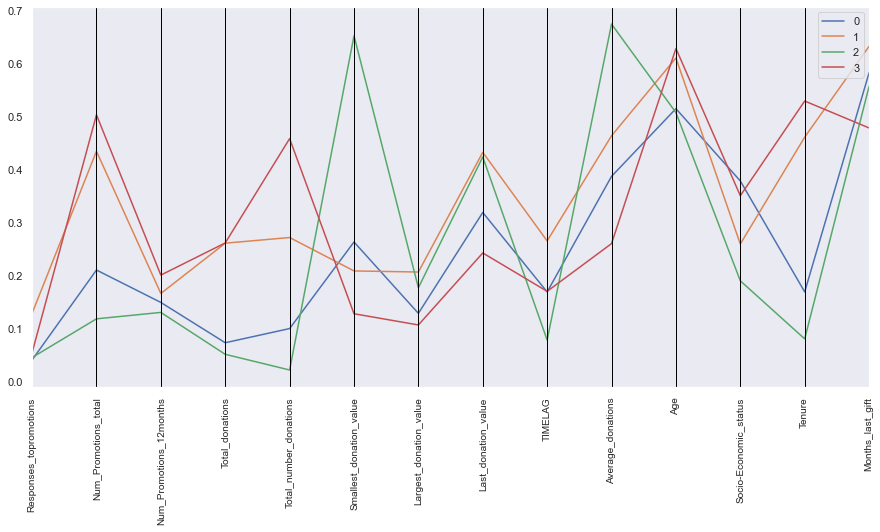

In [145]:
plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(hier_labeled_normalized, class_column = 'hc_labels', color=sns.color_palette())
plt.xticks(fontsize=10, rotation=90)

#### Assing labels to raw data

In [146]:
#characterization of clusters with not normalized data
Labeled_hc_data_raw = pd.concat((km_hier_raw, pd.Series(hc_labels, name='hc_labels')), axis=1)
#try printing Labeled_hc_data without grouping
hc_data_raw = Labeled_hc_data_raw.groupby('hc_labels').mean()
hc_data_raw

,Responses_topromotions,Num_Promotions_total,Num_Promotions_12months,Total_donations,Total_number_donations,Smallest_donation_value,Largest_donation_value,Last_donation_value,TIMELAG,Average_donations,Age,Socio-Economic_status,Tenure,Months_last_gift
hc_labels,,,,,,,,,,,,,,
0,2.063877,31.101841,11.742531,48.955952,4.418308,7.915555,17.280506,15.973340,6.783229,12.414267,55.492116,2.136798,3.375703,26.074605
1,6.457987,57.756402,12.502276,140.383086,10.256568,6.277037,24.682396,21.644672,10.632766,14.612859,61.704086,1.779846,7.461802,27.022267
2,2.295531,20.148959,10.895758,38.326033,1.761929,19.580923,21.866524,21.210464,3.154939,20.660619,55.012999,1.571748,2.135658,25.586517
3,2.740415,65.942977,14.062317,140.601461,16.596642,3.854616,15.199390,12.156204,6.829883,8.774195,62.867994,2.053094,8.414984,24.098225


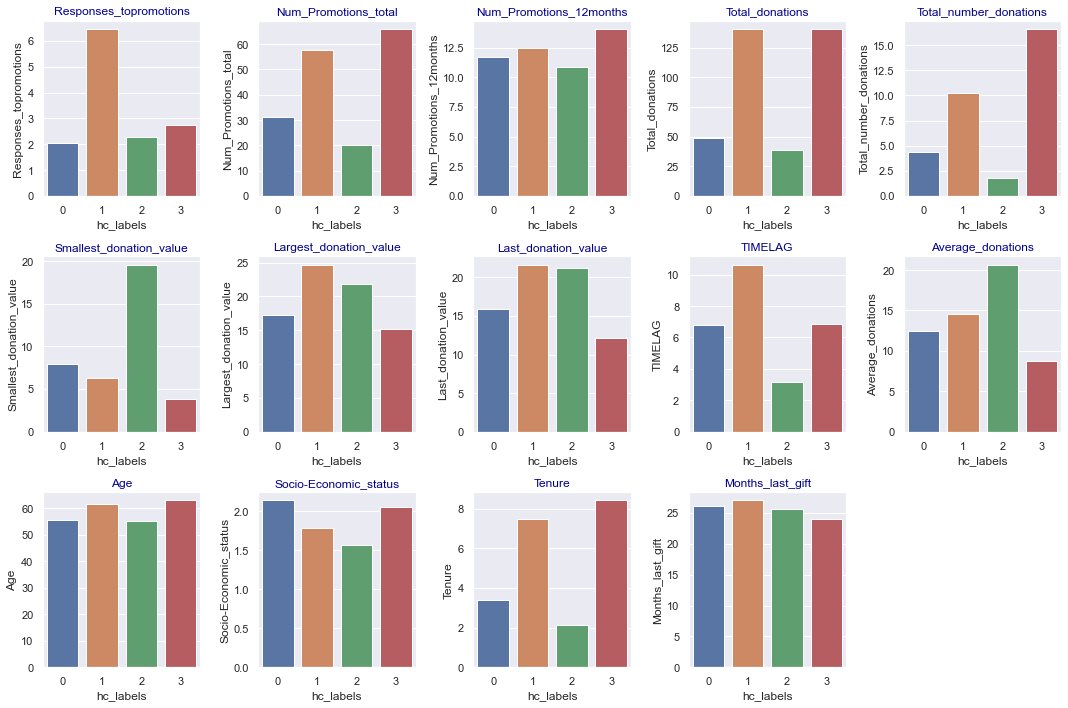

In [158]:
#visualization of the metric features of each cluster 
features=['Responses_topromotions', 'Num_Promotions_total',
       'Num_Promotions_12months', 'Total_donations', 'Total_number_donations',
       'Smallest_donation_value', 'Largest_donation_value',
       'Last_donation_value', 'TIMELAG', 'Average_donations', 'Age',
       'Socio-Economic_status', 'Tenure', 'Months_last_gift']
plt.figure(figsize=(15,10))
for i,j in enumerate(features):
    plt.subplot(3,5,i+1)
    sns.barplot(hc_data_raw.index,hc_data_raw[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

#### Assing labels to encoded data


In [151]:
#characterization of clusters with not normalized data
Labeled_hc_encoded = pd.concat((km_hier_encoded, pd.Series(hc_labels, name='hc_labels')), axis=1)
#try printing Labeled_hc_data without grouping
hc_data_encoded = Labeled_hc_encoded.groupby('hc_labels').mean()
hc_data_encoded['hc_labels'] = hc_data_encoded.index
hc_data_encoded

,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DE,State_FL,State_GA,...,RFA_2F_1,RFA_2F_2,RFA_2F_3,RFA_2F_4,Program_Donor_,Program_Donor_X,Program_Donor_XX,Urbanicity_level_Urban,HIT_binary_Yes,hc_labels
hc_labels,,,,,,,,,,,,,,,,,,,,,
0,0.003216,0.020728,0.011018,0.024604,0.178024,0.020344,0.000210,0.000028,0.089162,0.038999,...,0.527061,0.191574,0.164489,0.116877,0.977166,0.022567,0.000267,0.378784,0.634501,0
1,0.002412,0.015103,0.009489,0.027049,0.199325,0.023578,0.000109,0.000042,0.082874,0.035187,...,0.625824,0.229542,0.096061,0.048573,0.927866,0.071399,0.000735,0.330971,0.526734,1
2,0.006228,0.015188,0.009465,0.024267,0.220791,0.023827,0.000521,0.000111,0.078885,0.044963,...,0.851145,0.122036,0.022881,0.003938,0.980997,0.019003,0.000000,0.305192,0.643379,2
3,0.001181,0.018849,0.012427,0.023836,0.152328,0.019745,0.000221,0.000000,0.091855,0.029127,...,0.312771,0.267449,0.226086,0.193693,0.866164,0.130541,0.003295,0.325116,0.579912,3


In [153]:
States=['State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
       'State_CT', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA',
       'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA',
       'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO',
       'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH',
       'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK',
       'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN',
       'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI',
       'State_WV', 'State_WY']
Demo=['Gender_F', 'Gender_M',
     'Gender_U', 'Urbanicity_level_Urban']
Donor_Behaviour=['Sweepstakes_donor_X', 'RFA_2F_1', 'RFA_2F_2', 'RFA_2F_3', 'RFA_2F_4',
                'Program_Donor_', 'Program_Donor_X', 'Program_Donor_XX','HIT_binary_Yes']

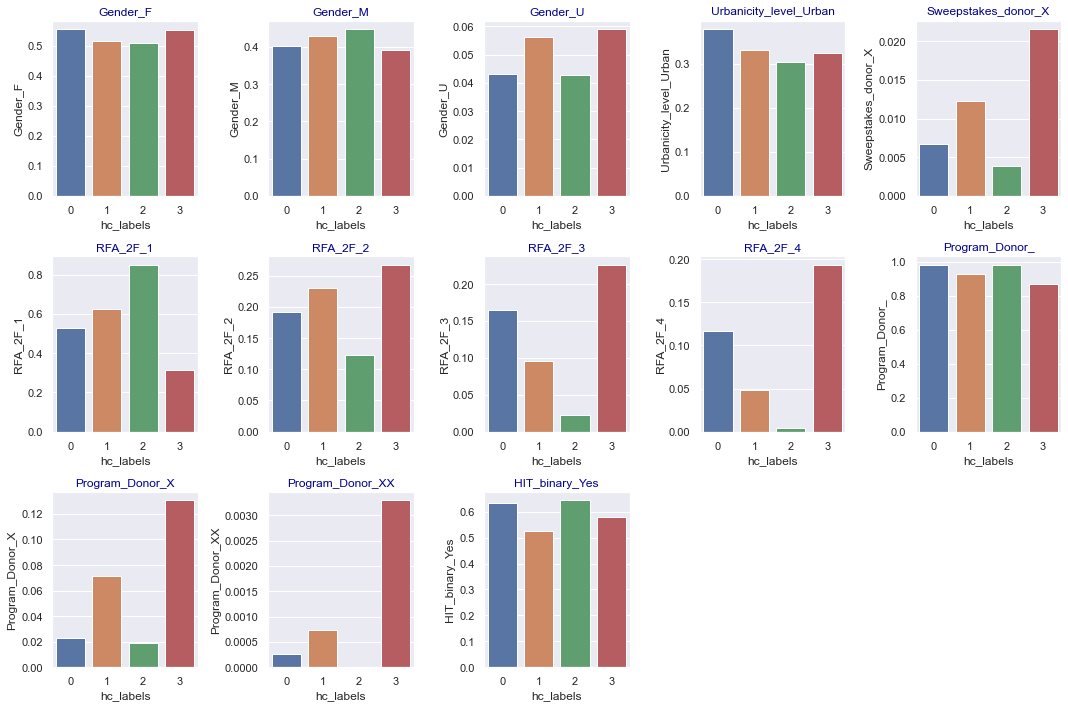

In [159]:
#visualization of some the non metric features of each cluster 
features=['Gender_F', 'Gender_M','Gender_U', 'Urbanicity_level_Urban', 'Sweepstakes_donor_X',
         'RFA_2F_1', 'RFA_2F_2', 'RFA_2F_3', 'RFA_2F_4',
         'Program_Donor_', 'Program_Donor_X', 'Program_Donor_XX','HIT_binary_Yes']
plt.figure(figsize=(15,10))
for i,j in enumerate(features):
    plt.subplot(3,5,i+1)
    sns.barplot(hc_data_encoded.index,hc_data_encoded[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

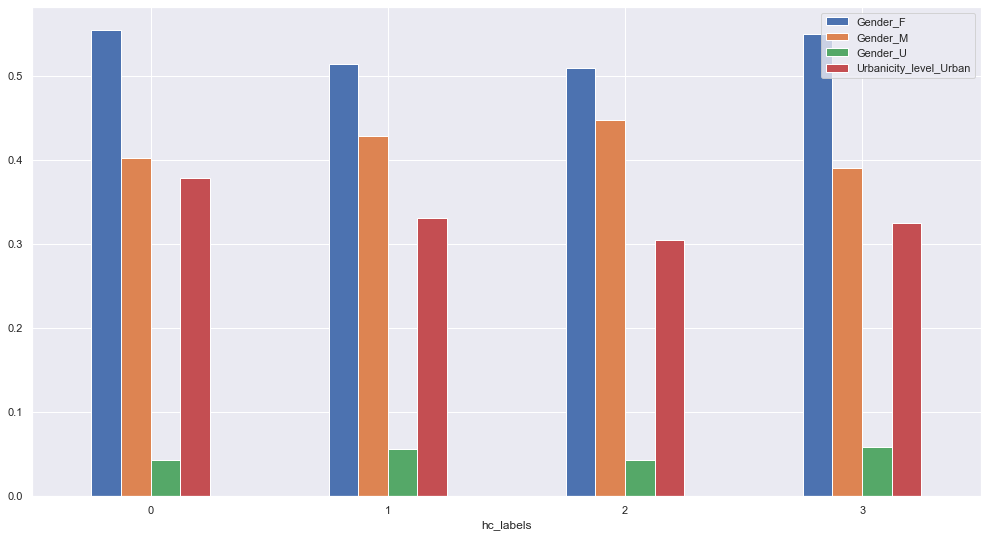

In [162]:
#visualization of the demographic features of each cluster 
axes = hc_data_encoded.plot.bar(x='hc_labels',y=Demo, rot=0, figsize=(17,9))

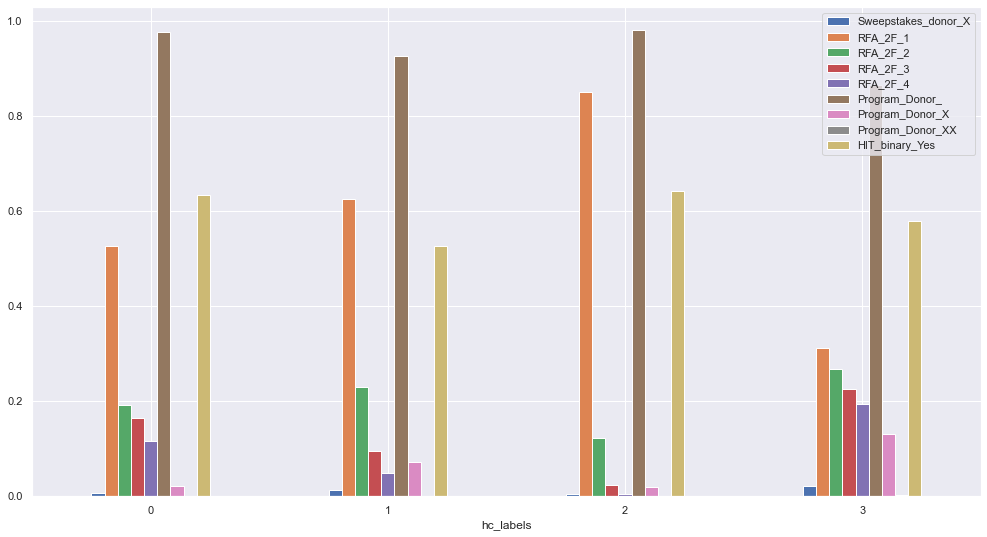

In [163]:
#visualization of the donor behavior features of each cluster 
axes = hc_data_encoded.plot.bar(x='hc_labels',y=Donor_Behaviour, rot=0, figsize=(17,9))

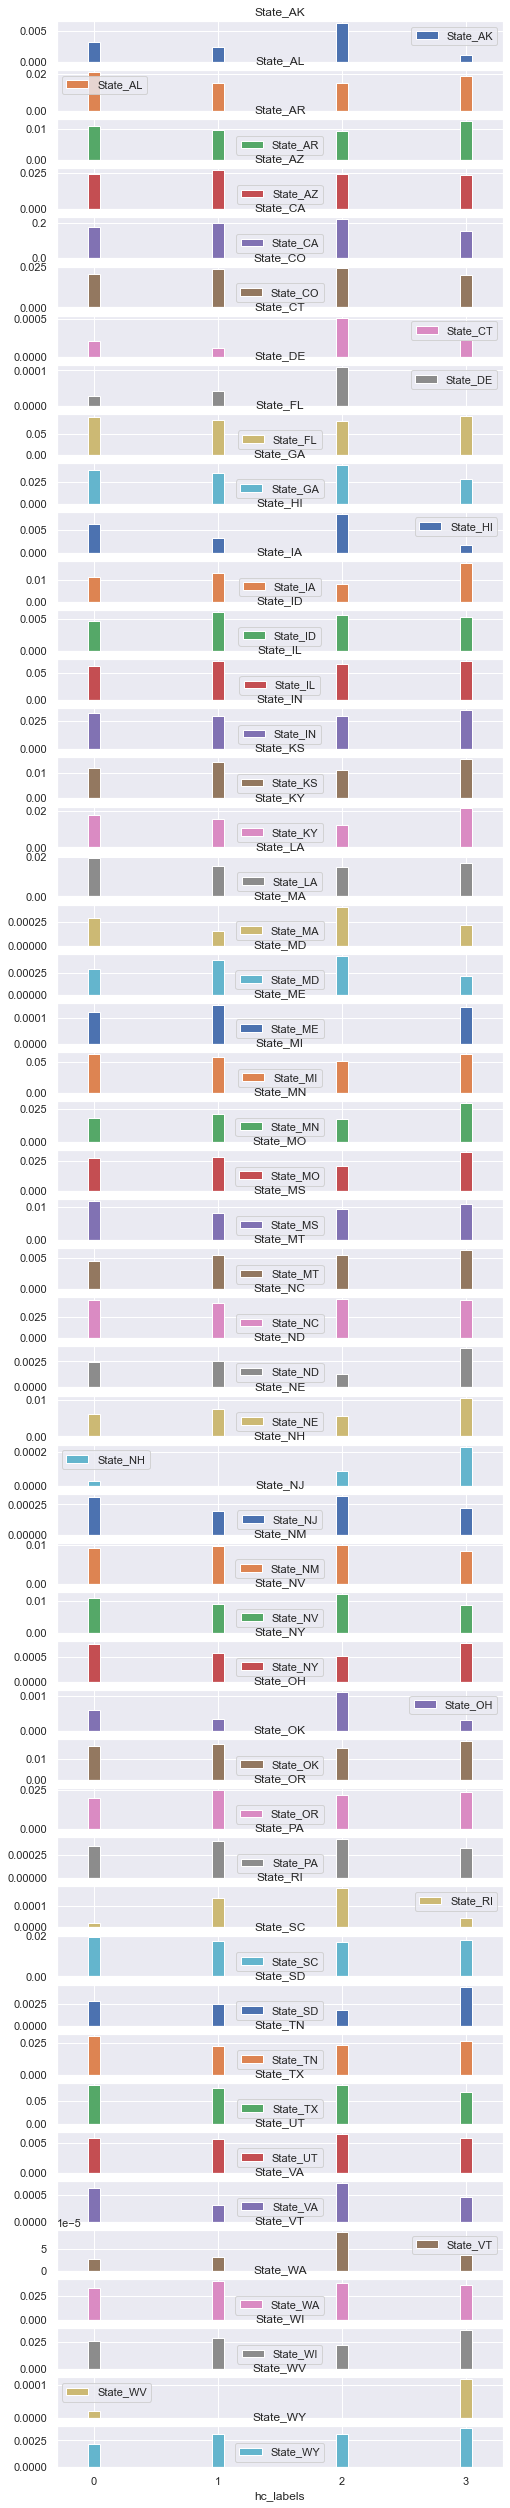

In [155]:
#visualization of the States the donors belong to for each cluster
axes = hc_data_encoded.plot.bar(x='hc_labels',y=States, rot=0, subplots=True, figsize=(8,45), width=0.1)
axes[1].legend(loc=2)

In [166]:
#the top 3 States the donors belong to for each cluster
Tops =pd.DataFrame(hc_data_encoded[States].apply(lambda x:list(hc_data_encoded[States].columns[np.array(x).argsort()[::-1][:3]]), axis=1).to_list(),  
                   columns=['Top1', 'Top2', 'Top3'])
Tops

,Top1,Top2,Top3
0,State_CA,State_FL,State_TX
1,State_CA,State_FL,State_TX
2,State_CA,State_TX,State_FL
3,State_CA,State_FL,State_TX


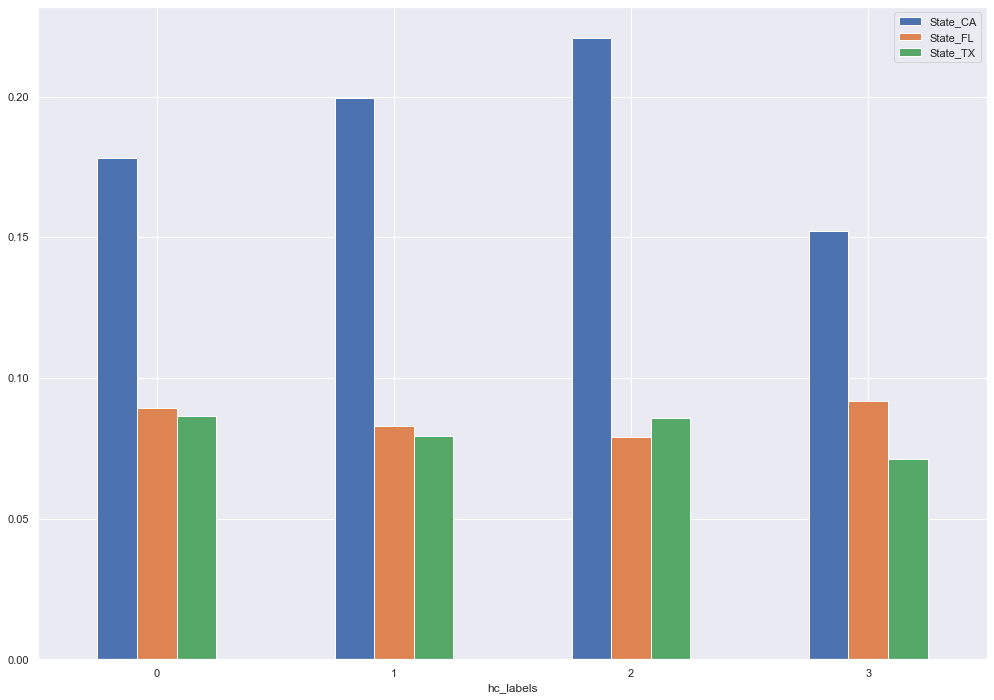

In [167]:
#visualization of the top donor's States of each cluster 
axes = hc_data_encoded.plot.bar(x='hc_labels',y=['State_CA', 'State_FL', 'State_TX'], 
                                rot=0, figsize=(17,12))